# Analysis of the Global Innovation Index (GII) by WIPO

Summary: https://www.wipo.int/web-publications/global-innovation-index-2024/en/index.html  
Dataset: https://www.wipo.int/publications/de/details.jsp?id=4756&plang=DE


## Download & Preprocess Data

In following code cells, we download the data and preprocess it for further analysis.

In [3]:
import wget
import os.path
import pandas as pd

filename = "../data/GII_2024.xlsx"
if not os.path.isfile(filename):
    url = "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2024-tech1.xlsx"
    filename = wget.download(url, out=filename)

GII_2024 = pd.read_excel(filename, sheet_name=None)



In [4]:
def download(filename, url):
    if not os.path.isfile(filename):
        filename = wget.download(url, out=filename)

filename_2023 = "../data/GII_2023.xlsx"
filename_2022 = "../data/GII_2022.xlsx"
filename_2021 = "../data/GII_2021.xlsx"
# filename_historical = "../data/GII_historical.xlsx"
download(filename_2023, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2023-tech1.xlsx")
download(filename_2022, "https://www.wipo.int/edocs/pubdocs/en/wipo-pub-2000-2022-tech1.xlsx")
download(filename_2021, "https://www.wipo.int/edocs/pubdocs/en/wipo_pub_2000-tech1.xlsx")


# import requests
# headers = {"User-Agent": "Mozilla/5.0"}
# response = requests.get("https://data.mendeley.com/public-files/datasets/cvkdzr8tv3/files/18c1e6f1-af82-4e51-97d8-ac9071cf4ae3/file_downloaded", headers=headers)
# with open(filename_historical, 'wb') as file:
#     file.write(response.content)


GII_2023 = pd.read_excel(filename_2023, sheet_name=None)
GII_2022 = pd.read_excel(filename_2022, sheet_name=None)
GII_2021 = pd.read_excel(filename_2021, sheet_name=None)

//TODO: rename get_europe function, what does it actually do?

In [5]:
def get_europe(in_df, data_name = "Data", economies_name = "Economies", iso_name = "ISO3", economy_name_name = "ECONOMY_NAME", 
               reguncode_name = "REG_UN_CODE", regun_name = "REG_UN"):
    
    '''The get_europe function processes input data frames related to global innovation index (GII) data and extracts information specific to European countries'''
    
    gii_data = in_df[data_name]
    #display(gii_data)
    gii_economies = in_df[economies_name]
    #display(gii_economies)

    joined = gii_data.merge(gii_economies, on=iso_name, suffixes=["", "_joined_r"]).drop(columns=economy_name_name + "_joined_r")
    #display(joined)

    gii_data_eu = joined[joined[reguncode_name] == "EUR"].drop(columns=[regun_name, reguncode_name])
    #display(gii_data_eu)
    return gii_data_eu

    
    
    

In [6]:
dfs = GII_2024

In [7]:
#gii_data_eu = get_europe(dfs_2021, "GII 2021 Data", "Economies in Context", "ISO2", "Economy", reguncode_name="RegionUNcode", regun_name="RegionUN")

In [8]:
for year in [2022, 2023, 2024]:
    dfs = globals()["GII_" + str(year)]
    gii_data_eu = get_europe(dfs)
    globals()["gii_data_eu_" + str(year)] = gii_data_eu

In [9]:
gii_data_eu = (get_europe(dfs))




EU countries sorted by innovation level

In [10]:
def get_display_data():
    pure_rank = gii_data_eu[gii_data_eu["NUM"].isnull()]
    display_data = pure_rank.sort_values("RANK")[["RANK", "ECONOMY_NAME", "SCORE"]]
    display_data.rename(columns={"RANK": "GLOBAL_RANK"}, inplace=True)
    display_data.index = range(1, len(display_data) + 1)
    return display_data

display_data = get_display_data()

display(display_data)

,GLOBAL_RANK,ECONOMY_NAME,SCORE
1,1.0,Switzerland,67.473082
2,2.0,Sweden,64.524365
3,5.0,United Kingdom,61.049318
4,7.0,Finland,59.436931
5,8.0,Netherlands (Kingdom of the),58.833036
6,9.0,Germany,58.082837
7,10.0,Denmark,57.114019
8,12.0,France,55.413323
9,16.0,Estonia,52.307935
10,17.0,Austria,50.276568


Get all the scores in a nice format

In [11]:
def get_nice_table(gii_data_eu):
    gii_data_eu["NUM"] = gii_data_eu["NUM"].fillna("Final")
    df_scores = gii_data_eu.pivot_table(index='ECONOMY_NAME', columns='NUM', values='SCORE')
    df_scores.head()
    return gii_data_eu, df_scores

gii_data_eu, df_scores = get_nice_table(gii_data_eu)
#df_scores.head()

Check for NaNs

In [12]:
print(len(df_scores))
nans = df_scores.isna().sum()
nans[nans > 5]

39


NUM
IN.1.3.2      8
IN.2.1.2      6
IN.4.1.1      8
IN.4.1.3     28
IN.4.2.1     13
IN.4.2.2      6
OUT.6.1.3    15
OUT.7.1.1     7
OUT.7.2.3    18
dtype: int64

Keep only raw values

//TODO: Warum gibt es in der folgenden Funktion keine Übergabeparameter?

In [13]:
def get_raw_data_index_structure(in_df:pd.DataFrame):
    gii_index_structure = in_df["Index Structure"]
    gii_index_structure = gii_index_structure.set_index("NUM")

    indicators = gii_index_structure[gii_index_structure["LEVEL"] == "Indicator"].index.tolist()

    df_scores_raw = df_scores[indicators]
    df_scores_raw.head()
    return df_scores_raw, gii_index_structure

df_scores_raw, gii_index_structure = get_raw_data_index_structure(dfs)

## Plots

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

### Correlation

In this step we cacluate the correlation matrix between different indicators of the GII and additional the GII score itself. 
Our hypothesis is that some indicators are more important than others and that they are correlated with the GII score. So in essence we want to find out which indicators are the most important for the GII score.

#### Cross Correlation between Indicators

In this step we calculate the cross correlatiton between each indicator of the GII. (GII data 2024)

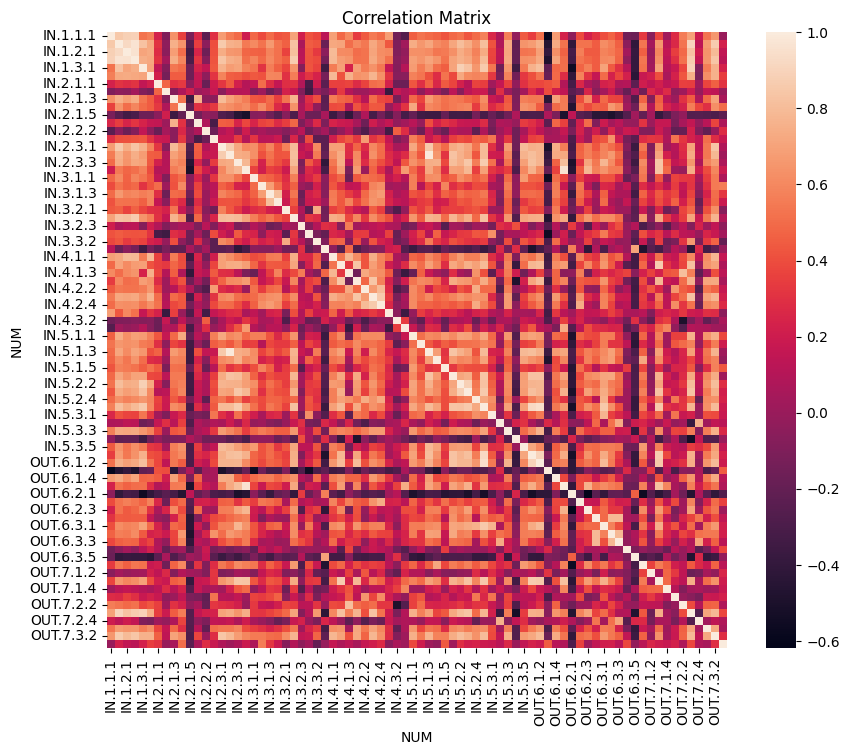

In [15]:
def get_corr_matrix(df_scores_raw):
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_scores_raw.corr(),)
    plt.title("Correlation Matrix")
    plt.show()

get_corr_matrix(df_scores_raw)

From the Crosscorrelation matrix above we can extract pairs with high correlation. It makes sense that some indicators in a pillar are correlated (depict similar information). But it is also interesting to see if there are indicators from different pillars that are correlated. This could indicate that the pillars are not independent from each other.

In [16]:
raw_corr = df_scores_raw.corr()
c_rate = 0.8
high_corr = raw_corr[abs(raw_corr) > c_rate]

In [17]:
high_corr_pairs = []
for i in range(len(raw_corr.columns)):
    for j in range(i+1, len(raw_corr.columns)):
        if abs(raw_corr.iloc[i,j]) > c_rate:
            high_corr_pairs.append({
                'Feature 1': raw_corr.index[i],
                'Feature 2': raw_corr.columns[j],
                'Correlation': raw_corr.iloc[i,j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs)

high_corr_df['Correlation'] = high_corr_df['Correlation'].round(3)

print(high_corr_df)

    Feature 1  Feature 2  Correlation
0    IN.1.1.1   IN.1.1.2        0.852
1    IN.1.1.1   IN.1.2.1        0.885
2    IN.1.1.1   IN.1.2.2        0.892
3    IN.1.1.2   IN.1.2.1        0.921
4    IN.1.1.2   IN.1.2.2        0.965
..        ...        ...          ...
68   IN.5.2.5  OUT.7.3.2        0.803
69  OUT.6.1.1  OUT.6.1.2        0.894
70  OUT.6.1.1  OUT.7.1.3        0.864
71  OUT.6.1.2  OUT.7.1.3        0.849
72  OUT.6.1.5  OUT.7.1.3        0.821

[73 rows x 3 columns]


In [18]:
import itertools
import pandas as pd
import math
#naive "clustering"
def find_high_correlation_clusters(raw_corr, c_rate):
    # Initialize list to store clusters
    clusters = []

    # find 4 or 5-feature clusters where all of them are above a set rate
    for r in range(4, 5):
        print("r= " + str(r))
        #get permutations
        for combo in itertools.combinations(raw_corr.columns, r):
            # iterate over all pairs of two, check if correlation > the c_rate, if not -> no longer a valid cluster
            valid_cluster = True
            for pair in itertools.combinations(combo, 2):
                corr = raw_corr.loc[pair[0], pair[1]]
                if abs(corr) <= c_rate:
                    valid_cluster = False
                    break

            if valid_cluster:
                clusters.append(combo)

    return clusters

c_rate = 0.8
clusters = find_high_correlation_clusters(raw_corr, c_rate)

# Display clusters
for i, cluster in enumerate(clusters):
    print(f"Cluster {i+1}: {cluster}")



r= 4
Cluster 1: ('IN.1.1.1', 'IN.1.1.2', 'IN.1.2.1', 'IN.1.2.2')
Cluster 2: ('IN.1.1.2', 'IN.1.2.1', 'IN.1.2.2', 'IN.3.2.2')
Cluster 3: ('IN.1.1.2', 'IN.1.2.1', 'IN.1.2.2', 'OUT.7.2.3')
Cluster 4: ('IN.1.1.2', 'IN.1.2.2', 'IN.2.3.1', 'IN.3.2.2')
Cluster 5: ('IN.1.1.2', 'IN.1.2.2', 'IN.2.3.1', 'OUT.7.3.2')
Cluster 6: ('IN.1.1.2', 'IN.1.3.1', 'IN.5.2.2', 'IN.5.2.5')
Cluster 7: ('IN.1.1.2', 'IN.1.3.1', 'IN.5.2.2', 'OUT.7.2.3')
Cluster 8: ('IN.1.1.2', 'IN.5.2.2', 'IN.5.2.5', 'OUT.7.3.2')
Cluster 9: ('IN.1.3.1', 'IN.5.2.2', 'IN.5.2.3', 'IN.5.2.5')
Cluster 10: ('IN.1.3.1', 'IN.5.2.2', 'IN.5.2.3', 'OUT.7.2.3')
Cluster 11: ('IN.2.3.2', 'IN.5.1.3', 'IN.5.2.1', 'OUT.6.1.1')
Cluster 12: ('IN.2.3.3', 'IN.5.2.1', 'IN.5.2.5', 'OUT.6.1.1')
Cluster 13: ('IN.2.3.3', 'IN.5.2.3', 'IN.5.2.5', 'OUT.6.1.1')
Cluster 14: ('IN.2.3.3', 'IN.5.2.3', 'IN.5.2.5', 'OUT.7.1.3')
Cluster 15: ('IN.2.3.3', 'IN.5.2.3', 'OUT.6.1.1', 'OUT.7.1.3')
Cluster 16: ('IN.2.3.3', 'IN.5.2.5', 'OUT.6.1.1', 'OUT.7.1.3')
Cluster 17: ('I

#### Correlation between Indicators and GII Score

In this step we calculate the correlation between each indicator and the final GII score. This will give us an idea of which indicators could be important for the GII score.

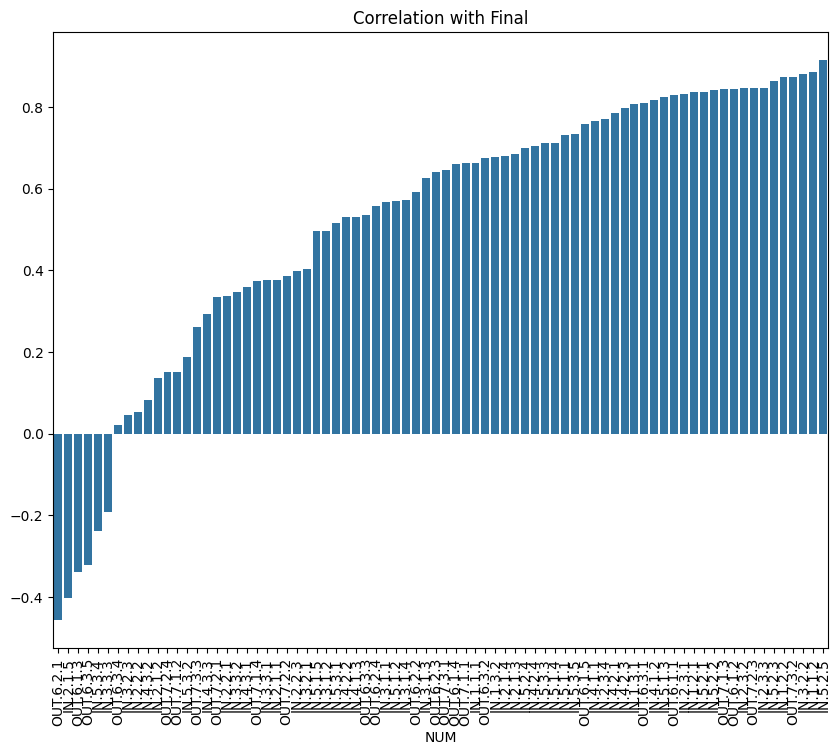

,NAME,DESCRIPTION,corr_w_final
NUM,,,
IN.1.1.2,Government effectiveness*,Index that reflects perceptions of the quality...,0.884958
IN.3.2.2,Logistics performance*,A multidimensional assessment of logistics per...,0.881405
OUT.7.3.2,GitHub commits/mn pop. 15–69,GitHub is the world’s largest host of source c...,0.874284
IN.1.2.2,Rule of law*,Index that reflects perceptions of the extent ...,0.873435
IN.5.2.3,State of cluster development†,Average answer to the survey question: In your...,0.862144
IN.2.3.3,"Global corporate R&D investors, top 3, mn USD",Average expenditure on R&D of the top three gl...,0.846993
OUT.7.2.3,Entertainment and media market/th pop. 15–69,'The Global Telecom and Entertainment & Media ...,0.846177
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.845228
OUT.6.1.2,PCT patents by origin/bn PPP$ GDP,A PCT application refers to an international p...,0.844857


In [19]:
def get_correlation_final(df_scores_raw, df_scores):
    corr_with_final = df_scores_raw.corrwith(df_scores["Final"])

    plt.figure(figsize=(10, 8))
    g = sns.barplot(corr_with_final.sort_values(),)
    g.tick_params(axis='x', rotation=90)
    plt.title("Correlation with Final")
    plt.show()
    corr_top10 = abs(corr_with_final).sort_values(ascending=False).iloc[1:11]

    corr_top10_info = gii_index_structure.loc[corr_top10.index.to_list()][["NAME", "DESCRIPTION"]]
    corr_top10_info["corr_w_final"] = corr_top10
    display(corr_top10_info)

get_correlation_final(df_scores_raw, df_scores)

The top 10 indicators with the highest correlation to the GII score are depicted above. Maybe we can use this information and predict the GII score from these indicators.

Now we do the same for the GII 2023 data.

NUM,Final,IN.1.1.1,IN.1.1.2,IN.1.2.1,IN.1.2.2,IN.1.2.3,IN.1.3.1,IN.1.3.2,IN.2.1.1,IN.2.1.2,...,OUT.7.1.3,OUT.7.1.4,OUT.7.2.1,OUT.7.2.2,OUT.7.2.3,OUT.7.2.4,OUT.7.3.1,OUT.7.3.2,OUT.7.3.3,OUT.7.3.4
ECONOMY_NAME,,,,,,,,,,,,,,,,,,,,,
Albania,25.426758,52.777778,36.651440,47.102852,32.218405,74.603170,53.954953,NaN,21.385565,9.648313,...,0.000000,22.694029,27.476446,18.342725,NaN,0.447837,7.741508,3.771317,6.029725,55.618992
Austria,53.247123,72.222222,80.083817,77.101802,92.095958,100.000000,82.381093,51.480605,45.189719,43.837719,...,27.255222,54.866511,22.636486,49.409297,63.164926,14.123925,42.107159,68.236516,50.738715,71.040723
Belarus,26.843908,35.416667,15.466163,18.245015,7.494473,72.937295,NaN,4.519599,38.666950,NaN,...,0.000000,24.121034,8.100193,NaN,NaN,10.207383,1.973795,6.564798,24.203359,88.386522
Belgium,49.943794,69.444444,67.802012,76.940038,78.560653,76.897685,66.105904,51.643961,59.419361,39.246380,...,17.451351,33.098651,25.620989,21.352796,50.507709,10.344550,24.665911,63.684251,57.907580,61.864579
Bosnia and Herzegovina,27.148722,41.666667,8.000920,37.464880,31.550794,97.579759,11.226345,26.082013,NaN,61.455524,...,0.000000,18.293905,8.214390,23.867938,NaN,4.289960,3.383727,3.346740,7.018992,47.214588
Bulgaria,38.983933,53.472222,32.902192,53.735132,38.433751,98.774164,38.509407,27.496616,32.189920,39.053988,...,0.000000,49.535792,35.391919,26.436956,NaN,12.153309,28.393305,4.573171,27.948082,71.246694
Croatia,37.070583,69.444444,53.059774,55.128433,48.582797,85.918593,26.505267,1.017713,28.553388,NaN,...,0.761890,43.100161,35.403925,13.195547,NaN,10.132478,17.712134,12.824891,26.252244,70.768487
Czech Republic,44.833748,72.222222,67.392403,77.096638,72.703832,75.797572,45.888937,NaN,36.589477,47.501826,...,5.834382,38.595196,13.112512,40.194607,27.240408,100.000000,20.576460,59.116199,58.016614,74.755815
Denmark,58.733405,85.416667,92.066035,89.042571,96.443001,78.657863,77.205744,NaN,66.749240,37.205424,...,51.651933,54.493039,18.458265,36.488374,77.840740,18.759812,56.787779,100.000000,64.700137,76.415224


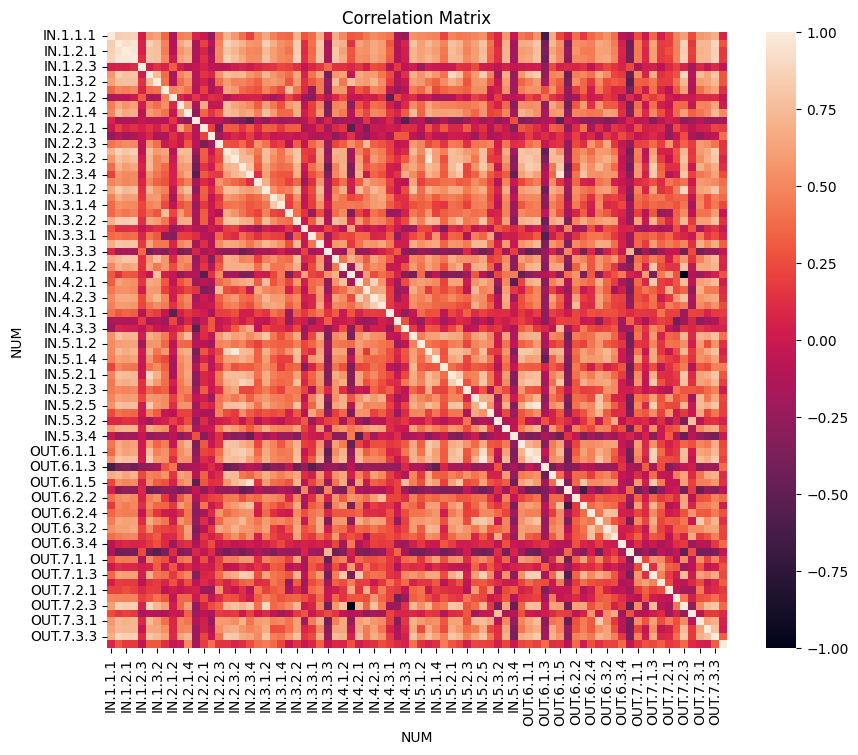

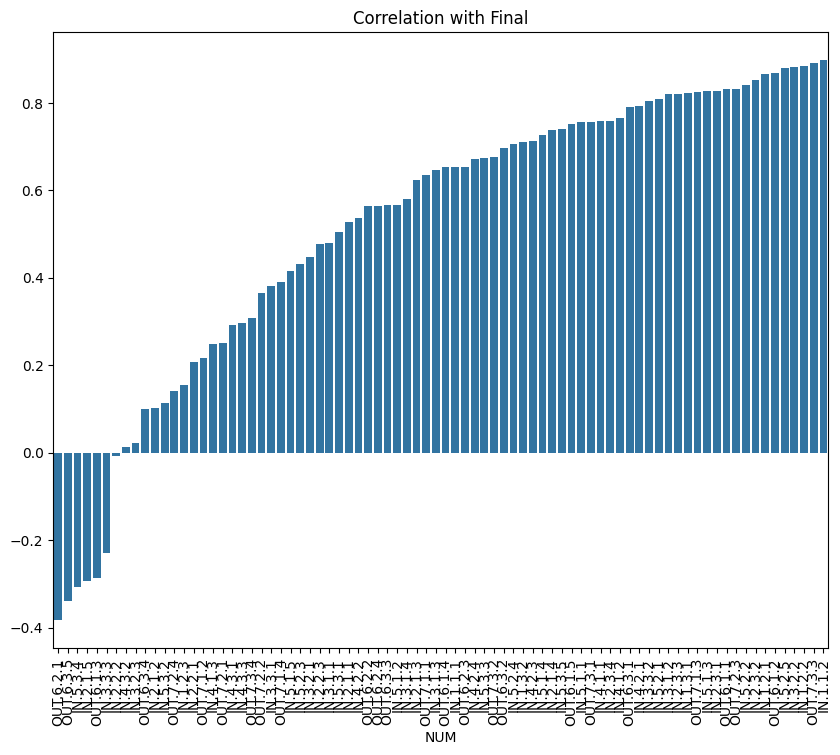

,NAME,DESCRIPTION,corr_w_final
NUM,,,
OUT.7.3.3,GitHub commits/mn pop. 15-69,GitHub is the worldâ€™s largest host of source...,0.890984
IN.1.2.2,Rule of law,Index that reflects perceptions of the extent ...,0.885219
IN.3.2.2,Logistics performance,A multidimensional assessment of logistics per...,0.881330
IN.5.2.5,Patent families/bn PPP$ GDP,A patent family is a set of interrelated paten...,0.879816
OUT.6.1.2,PCT patents by origin/bn PPP$ GDP,A PCT application refers to an international p...,0.868528
IN.1.2.1,Regulatory quality,Index that reflects perceptions of the ability...,0.866366
IN.2.3.2,"Gross expenditure on R&D, % GDP",Gross expenditure on R&D (GERD) is the total d...,0.852385
IN.5.2.2,State of cluster development,Average answer to the survey question: In your...,0.840780
OUT.7.2.3,Entertainment and media market/th pop. 15-69,The Global Entertainment & Media Outlook is a ...,0.832753


In [20]:
dfs = GII_2023
gii_data_eu = get_europe(dfs)



gii_data_eu, df_scores = get_nice_table(gii_data_eu)
df_scores_raw, gii_index_structure = get_raw_data_index_structure(dfs)
gii_index_structure = GII_2023["Index Structure"]
gii_index_structure = gii_index_structure.set_index("NUM")

indicators = ['Final']
indicators.extend(gii_index_structure[gii_index_structure["LEVEL"] == "Indicator"].index.tolist())

GII_2023_prepared = df_scores[indicators]
display(GII_2023_prepared)
get_corr_matrix(df_scores_raw)
get_correlation_final(df_scores_raw, df_scores)

Looking at the top 10 indicators for the GII 2023 data they are similar to the GII 2024 data buut not the same. This could giving us an indication that the GII score is not stable dependant on these indicators.



2024 from top copied
IN.1.1.2	Government effectiveness*	Index that reflects perceptions of the quality...	0.884958
IN.3.2.2	Logistics performance*	A multidimensional assessment of logistics per...	0.881405
OUT.7.3.2	GitHub commits/mn pop. 15–69	GitHub is the world’s largest host of source c...	0.874284
IN.1.2.2	Rule of law*	Index that reflects perceptions of the extent ...	0.873435
IN.5.2.3	State of cluster development†	Average answer to the survey question: In your...	0.862144
IN.2.3.3	Global corporate R&D investors, top 3, mn USD	Average expenditure on R&D of the top three gl...	0.846993
OUT.7.2.3	Entertainment and media market/th pop. 15–69	'The Global Telecom and Entertainment & Media ...	0.846177
IN.2.3.2	Gross expenditure on R&D, % GDP	Gross expenditure on R&D (GERD) is the total d...	0.845228
OUT.6.1.2	PCT patents by origin/bn PPP$ GDP	A PCT application refers to an international p...	0.844857
OUT.7.1.3

## Predictors

### Finding predictors for future innovation level

In this step we want to find out which indicators are the best predictors for the GII score. We will use a linear regression model to predict the GII score from the indicators.

In [21]:
import sklearn
import numpy as np

In [22]:
from sklearn.svm import LinearSVR
from  sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer


from sklearn.feature_selection import SelectFromModel
y = df_scores["Final"]
#X = df_scores_raw.drop(columns="Final")
X = df_scores_raw
#X.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)
if np.isnan(X_imputed).any():
    raise ValueError("There are still NaN values in X_imputed after imputation")

In [23]:
pd.DataFrame(X_imputed).isna().any().sum()

np.int64(0)

In [24]:

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_imputed,y)
importances = reg.feature_importances_



In [25]:
importances_df = pd.DataFrame(importances, index=X.columns, columns=["Importance"])

In [26]:
importances_df.head()

,Importance
NUM,
IN.1.1.1,0.000782
IN.1.1.2,0.008640
IN.1.2.1,0.025364
IN.1.2.2,0.069525
IN.1.2.3,0.000000


<Axes: xlabel='NUM'>

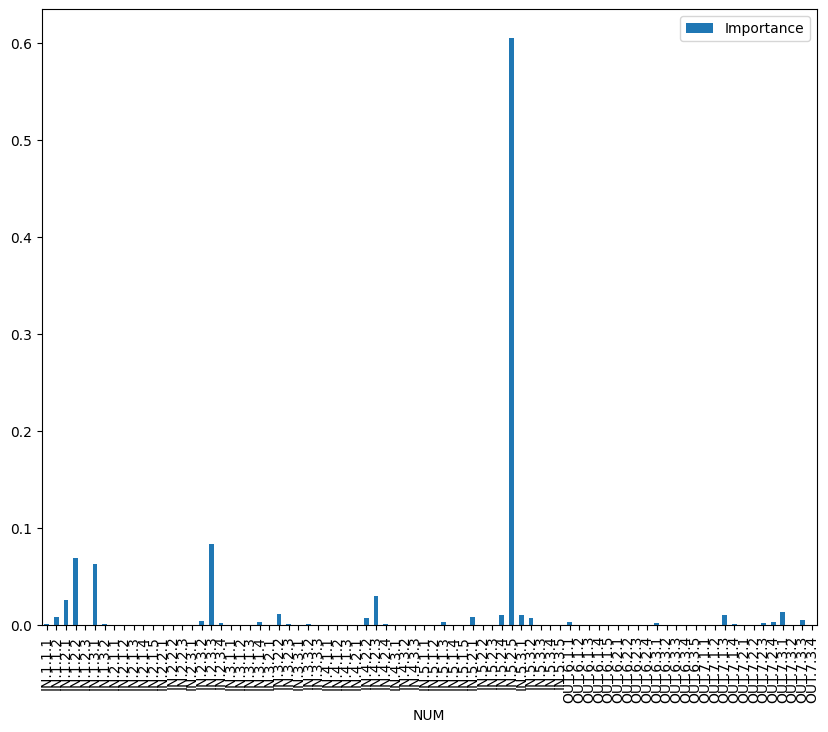

In [27]:
importances_df.plot(kind='bar', figsize=(10, 8))

In [28]:

lsvc = LinearSVR(C=0.01).fit(X_imputed, y)

model = SelectFromModel(lsvc, prefit=True)

model.get_support(True)

/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([ 2,  3,  4, 13, 14, 15, 17, 21, 22, 24, 28, 29, 31, 34, 40, 43, 48,
       49, 54, 55, 57, 58, 61, 62, 64, 65, 68, 69, 70, 71, 72, 74, 76, 78])

In [29]:
from sklearn.ensemble import ExtraTreesClassifier

# Eurostat Data Data Exploration

In this section we will use Eurostat data to compare the GII data with other indicators. We will use the Eurostat data to find out if there are other indicators that are correlated with the GII score.

## R&D Expenditure

In the first part we will look at the R&D expenditure of the EU countries.


### Download & Preprocess Data

The following code cells are mainly used for preprocessing the Eurostat data.


In [30]:
import eurostat

# Dataset 	GERD by sector of performance and socioeconomic objectives rd_e_gerdsobj92
# sectperf: TOTAL All sectors
# sectperf: BES Business enterprise sector
# sectperf: GVT Government sector
# sectperf: HES Higher education sector
# sectperf: PNP Private non-profit sector

# unit = unit of measure
# EUR_HAB = Euro per inhabitant
# MIO_EUR = Million Euro
# MIO_PPS = Million Purchasing Power Standard
# MIO_PPS_KP05 = Million Purchasing Power Standard per capita, 2005 prices

# geo = country
# EU27_2020 = European Union (27 countries)
# EA20 = Euro area (20 countries)

# Available flags:
# (e) estimated
# (p) provisional
# (d) definition differs (see metadata)
# (bd) break in time series, definition differs (see metadata)
# (b) break in time series
# (de) definition differs (see metadata), estimated
# (dp) definition differs (see metadata), provisional
# (ep) estimated, provisional
# (bp) break in time series, provisional
# (u) low reliability


RD_EXP_BY_SECTOR = eurostat.get_data_df("rd_e_gerdtot", True)
print(RD_EXP_BY_SECTOR.head())
print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())

countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()

# Patent applications https://ec.europa.eu/eurostat/databrowser/view/pat_ep_ntot/default/table?lang=en&category=scitech.ipr.pat.pat_h
PAT_APPLICATIONS_HIST = eurostat.get_data_df("pat_ep_ntot", True)
PAT_APPLICATIONS_NEW = eurostat.get_data_df("pat_ep_tot", True)

print(PAT_APPLICATIONS_HIST.head())

<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:35: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/3465110842.py:35: SyntaxWarning: invalid escape sequence '\T'
  print(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())
/tmp/ipykernel_125813/3465110842.py:37: SyntaxWarning: invalid escape sequence '\T'
  countries = RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique()


  freq sectperf     unit geo\TIME_PERIOD  1980_value 1980_flag  1981_value  \
0    A      BES  EUR_HAB              AT         NaN         :      51.466   
1    A      BES  EUR_HAB              BA         NaN         :         NaN   
2    A      BES  EUR_HAB              BE         NaN         :      92.121   
3    A      BES  EUR_HAB              BG         NaN         :         NaN   
4    A      BES  EUR_HAB              CH         NaN         :     226.259   

  1981_flag  1982_value 1982_flag  ...  2019_value 2019_flag  2020_value  \
0         d         NaN         :  ...     987.624               953.084   
1         :         NaN         :  ...       3.419                 3.630   
2                95.968            ...     972.758              1001.321   
3         :         NaN         :  ...      51.644                53.788   
4                   NaN         :  ...    1629.766                   NaN   

  2020_flag  2021_value 2021_flag  2022_value 2022_flag  2023_value 2023_f

Add a variable to check for time specific timespan.
Per county of origin.


<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/3019163643.py:20: SyntaxWarning: invalid escape sequence '\T'
  country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
/tmp/ipykernel_125813/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)
/tmp/ipykernel_125813/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)
/tmp/ipykernel_125813/3019163643.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(missing_values.index, rotation=90)


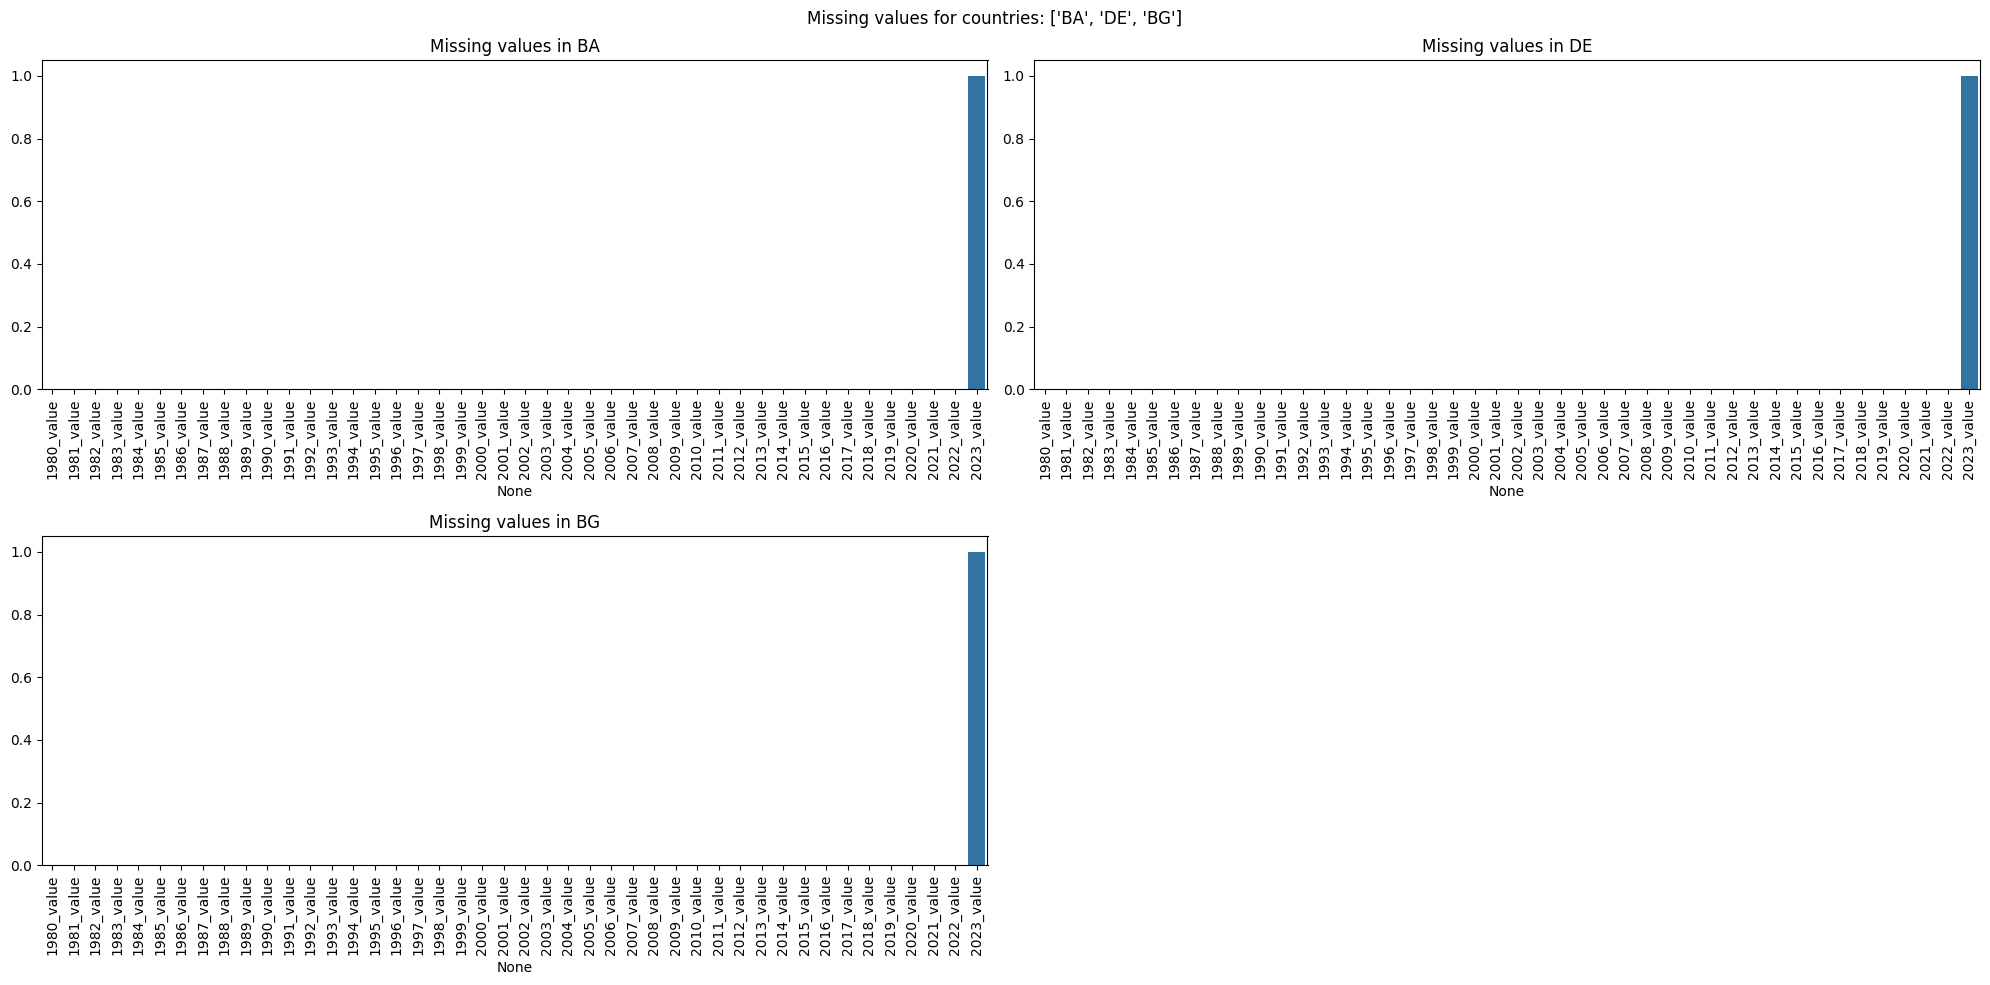

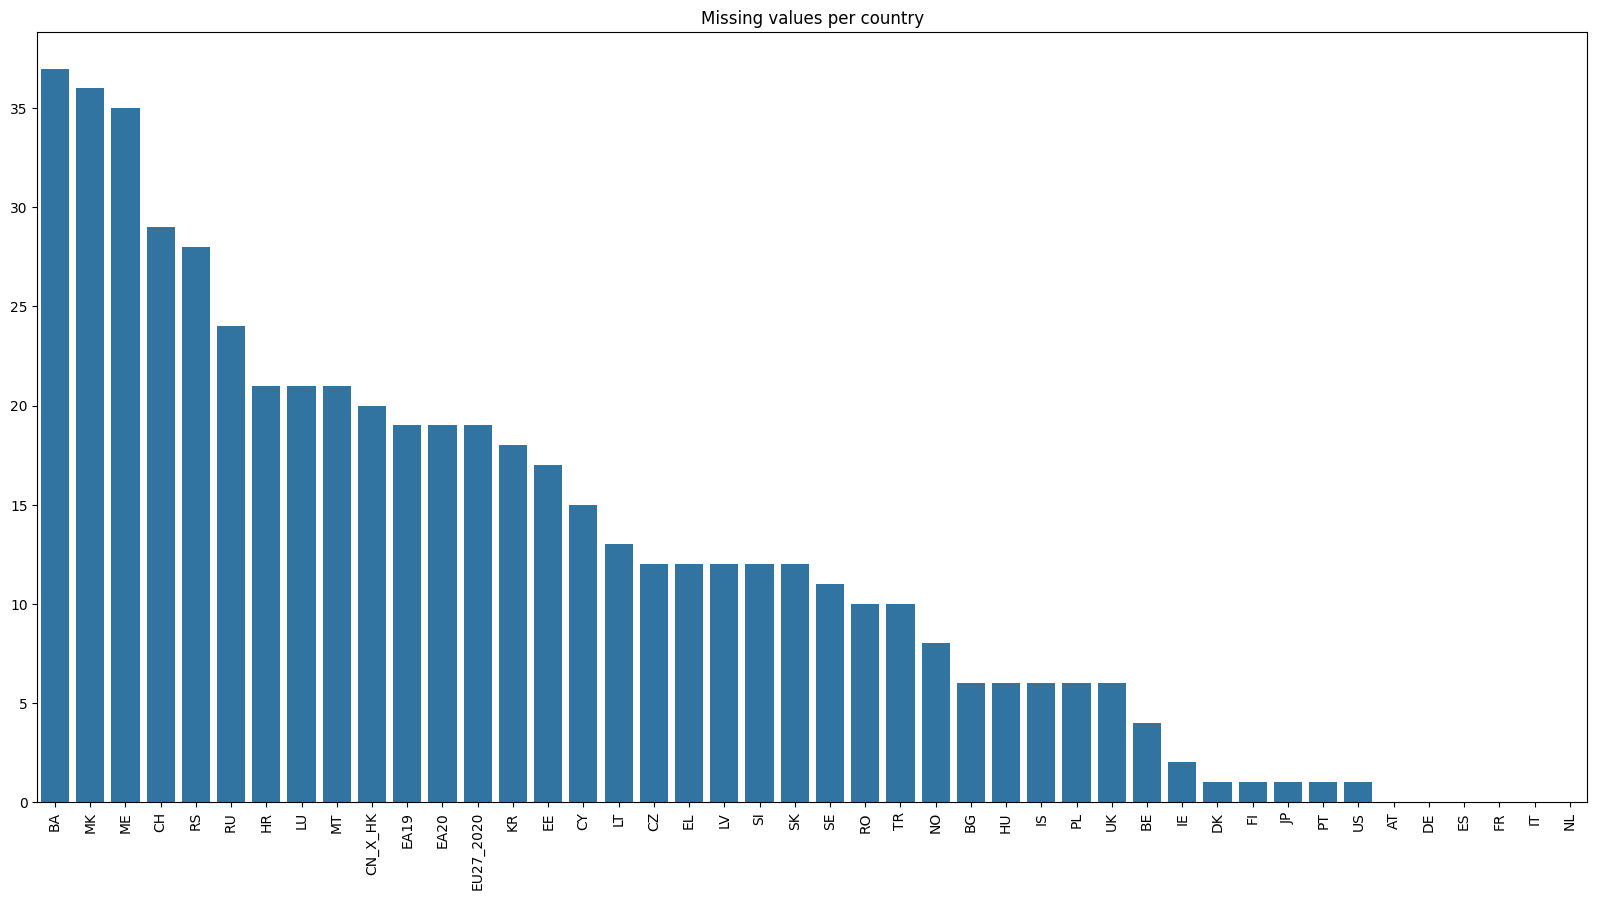

In [31]:
time_span = 43  # max timespan =43 current year - time_span
sector = "TOTAL"  # All sectors
unit = "EUR_HAB"  # Euro per inhabitant
# access the data this can be accessed like [-2*time_span:] but the first 4 columns should also be kepped since they have valueable information
import seaborn as sns
import matplotlib.pyplot as plt
import math

dataBySector = RD_EXP_BY_SECTOR[
    (RD_EXP_BY_SECTOR["sectperf"] == sector) & (RD_EXP_BY_SECTOR["unit"] == unit)
]
missingData = {}
# check for missing values per country


def getMissingDataForTimespan(dataBySector, time_span, plotCountries=[]):
    missingData = {}

    for country in countries:
        country_data = dataBySector[dataBySector["geo\TIME_PERIOD"] == country]
        missing_values = country_data.isnull().sum()
        missing_values = missing_values[
            missing_values.index.str.contains(r"\d{4}_value")
        ]
        missingData[country] = sum(missing_values[-time_span:])

    if len(plotCountries) == 0:
        return missingData

    # Plot for the specified countries
    num_cols = 2
    num_rows = math.ceil(len(plotCountries) / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axs = axs.flatten()
    fig.suptitle(f"Missing values for countries: {plotCountries}")
    for idx, country in enumerate(plotCountries):
        ax = axs[idx]
        sns.barplot(x=missing_values.index, y=missing_values.values, ax=ax)
        ax.set_xticklabels(missing_values.index, rotation=90)
        ax.set_title(f"Missing values in {country}")
    # Hide any unused subplots
    for ax in axs[len(plotCountries) :]:
        ax.set_visible(False)
    plt.tight_layout()
    plt.show()

    return missingData


missingData = getMissingDataForTimespan(dataBySector, time_span, ["BA", "DE", "BG"])
# plot the distribution of missing values per country
# sort the values by the number of missing values
missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country")
plt.show()

The top chart shows us for a timespan of 43 years many countries have missing values. Only a few like DE AT FR have values for all years.

Find the timespan where got the most data to support the analysis.


<>:24: SyntaxWarning: invalid escape sequence '\T'
<>:24: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/911752458.py:24: SyntaxWarning: invalid escape sequence '\T'
  time_span * len(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())


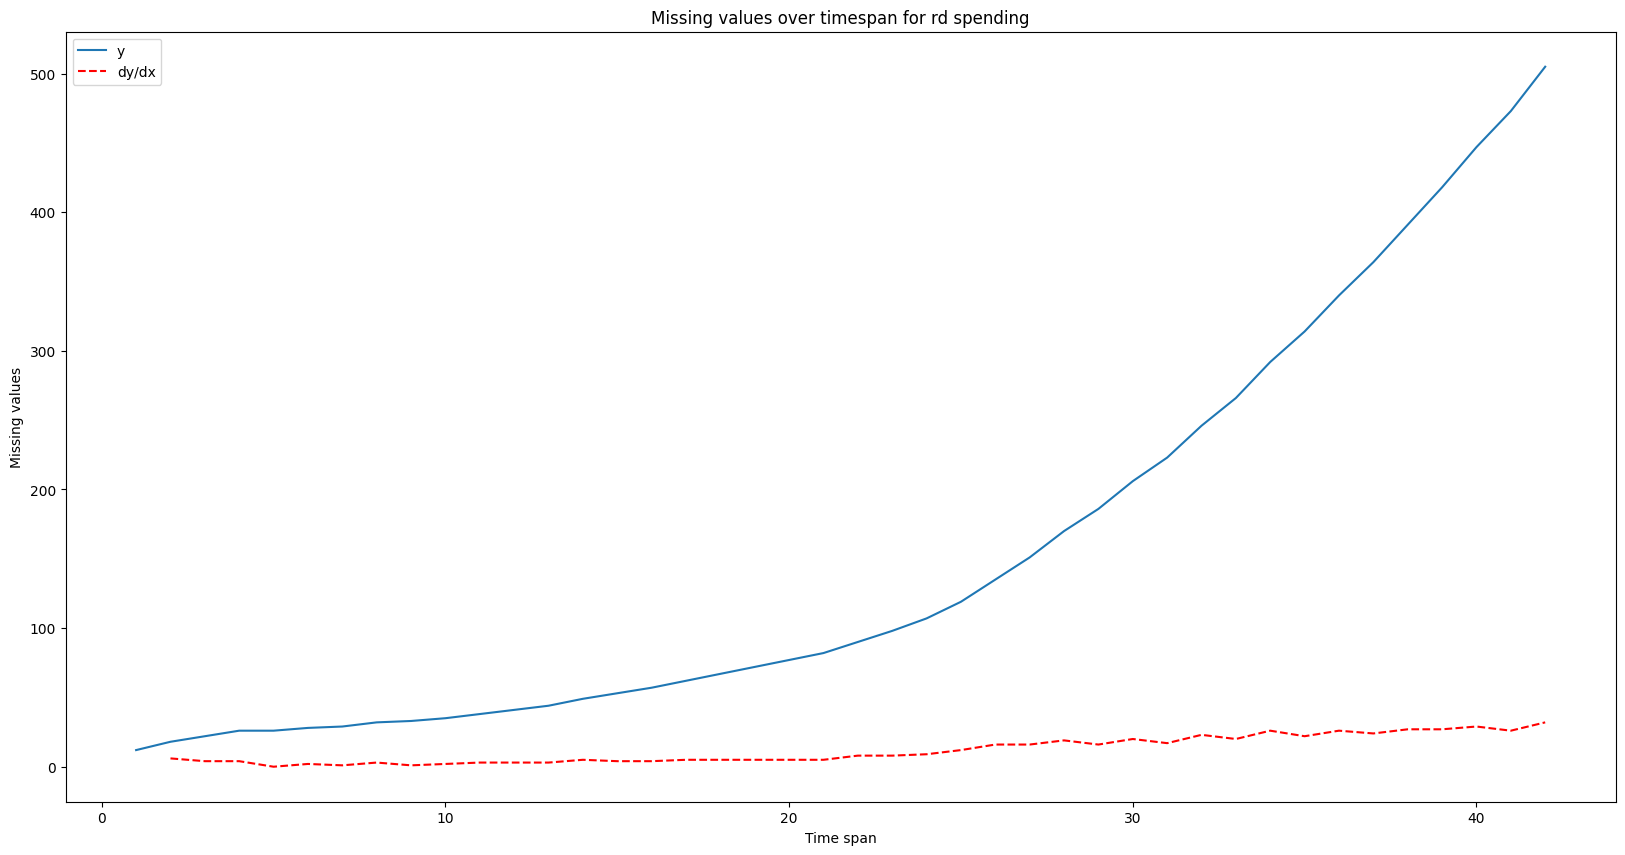

   x   y  y_total  rel_missing_values  dy/dx
0  1  12       44            0.272727    NaN
1  2  18       88            0.204545    6.0
2  3  22      132            0.166667    4.0
3  4  26      176            0.147727    4.0
4  5  26      220            0.118182    0.0


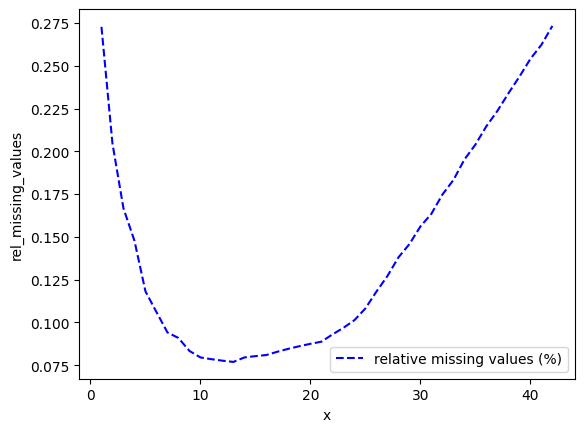

In [32]:
import pandas as pd



plotData = pd.DataFrame()


# add columns x and y


plotData["x"] = range(1, 43)


plotData["y"] = [
    sum(getMissingDataForTimespan(dataBySector, time_span, []).values())
    for time_span in range(1, 43)
]


# plotData["total_y"] = [sum(dataBySector.)]


plotData["y_total"] = [
    time_span * len(RD_EXP_BY_SECTOR["geo\TIME_PERIOD"].unique())
    for time_span in range(1, 43)
]


plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]



# Calculate the derivative (numerical approximation)


plotData["dy/dx"] = plotData["y"].diff()



# Plotting the data and its derivative


plt.figure(figsize=(20, 10))



# Plot the original data


sns.lineplot(data=plotData, x="x", y="y", label="y")



# Plot the derivative


sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)



plt.xlabel("Time span")


plt.ylabel("Missing values")


plt.title("Missing values over timespan for rd spending")
plt.legend()


plt.show()



print(plotData.head())


sns.lineplot(
    data=plotData,
    x="x",
    y="rel_missing_values",
    label="relative missing values (%)",
    linestyle="--",
    color="blue",
)


plt.show()

The chart above shows us that the longer the timespan the less countries have data. A sweet spot seems to be around 20 years.

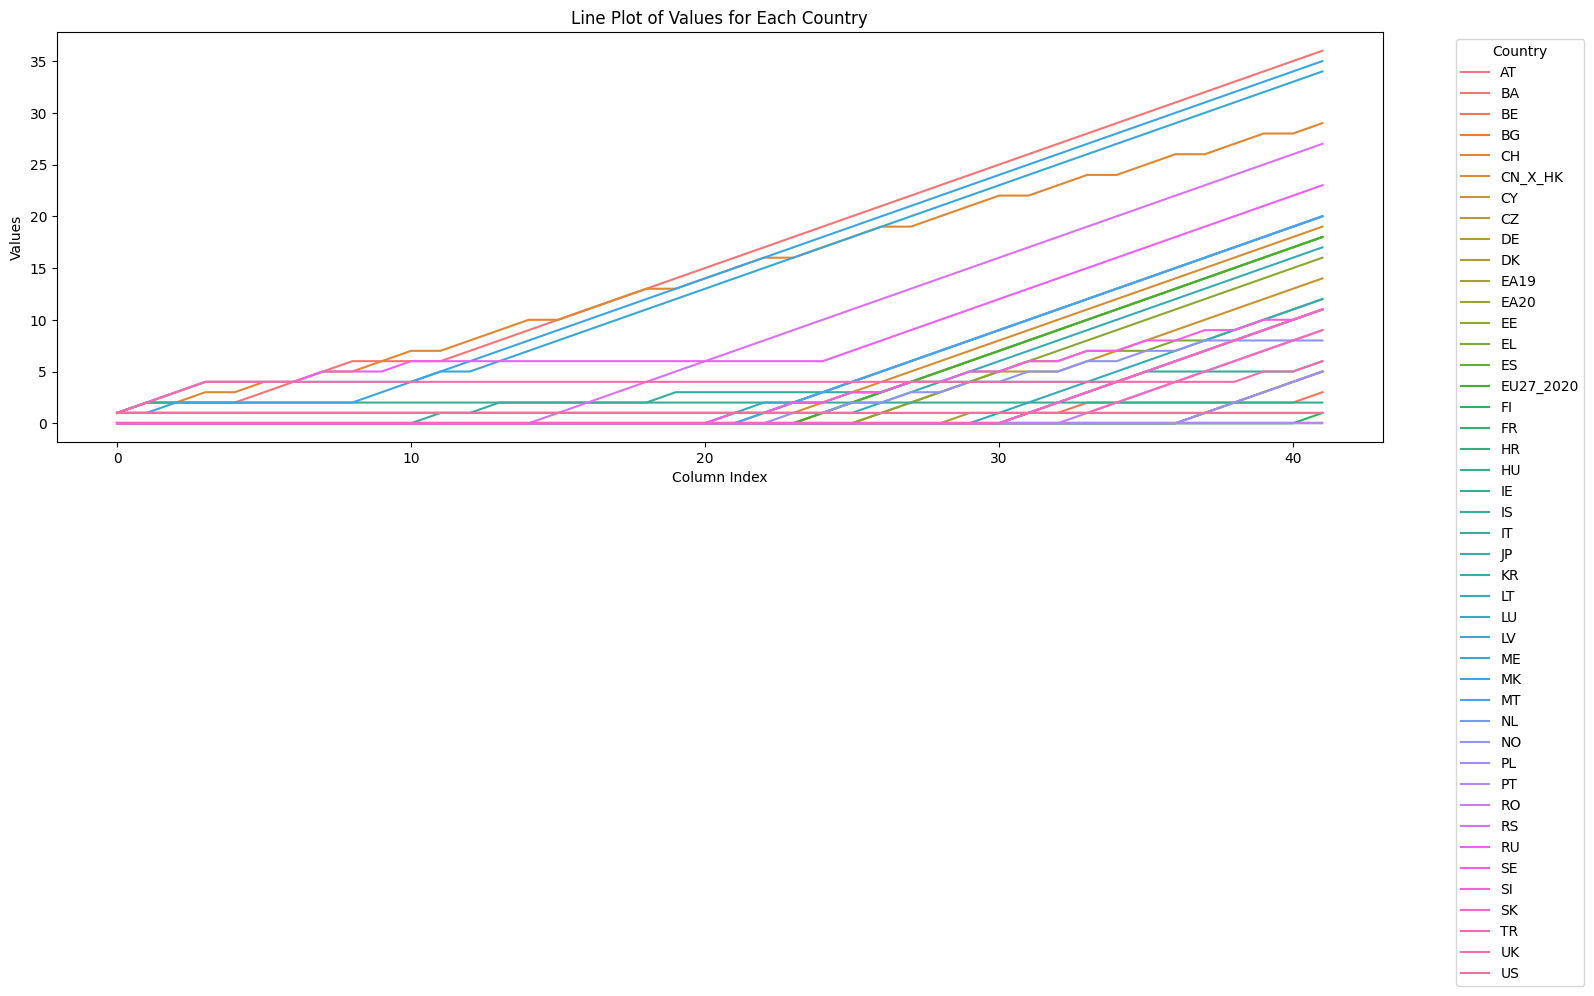

In [33]:
# print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(
    getMissingDataForTimespan(dataBySector, time_span) for time_span in range(1, 43)
)
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
# print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={"index": "Country"}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(
    id_vars="Country", var_name="Column", value_name="Value"
)

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x="Column", y="Value", hue="Country")

# Customize plot
plt.title("Line Plot of Values for Each Country")
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

Again the top chart shows that for most countries the missing values are beginning to increase after 20 years.

### Decisions so far

Based on the analysis so far, a suitable range for continuing would be a timespan of somewhere between 20 and 25 years. This is the timespan, where the share of missing values is quite small, but the timeframe itself is not to little.


## Analysis Patent Applications

The number of patent applications could als be an indicator for innovation. In this section we will look at the number of patent applications in the EU countries.

### Download & Preprocess Data

Similar to the Eurostat data, we will download and preprocess the patent application data.

<>:20: SyntaxWarning: invalid escape sequence '\T'
<>:20: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/2278643725.py:20: SyntaxWarning: invalid escape sequence '\T'
  time_span * len(filteredPatentApplications["geo\TIME_PERIOD"].unique())


    freq    unit geo\TIME_PERIOD  1978_value 1978_flag  1979_value 1979_flag  \
285    A  P_MHAB              AT         NaN         :       35.12             
286    A  P_MHAB              AU         NaN         :       11.52             
287    A  P_MHAB              BE         NaN         :       25.18             
288    A  P_MHAB              BG         NaN         :         NaN         :   
289    A  P_MHAB              BR         NaN         :        0.12             
290    A  P_MHAB              CA         NaN         :        5.94             
291    A  P_MHAB              CH         NaN         :      141.22             
292    A  P_MHAB              CY         NaN         :         NaN         :   
293    A  P_MHAB              CZ         NaN         :         NaN         :   
294    A  P_MHAB              DE         NaN         :       81.31             
295    A  P_MHAB              DK         NaN         :       21.54             
296    A  P_MHAB            EA18        

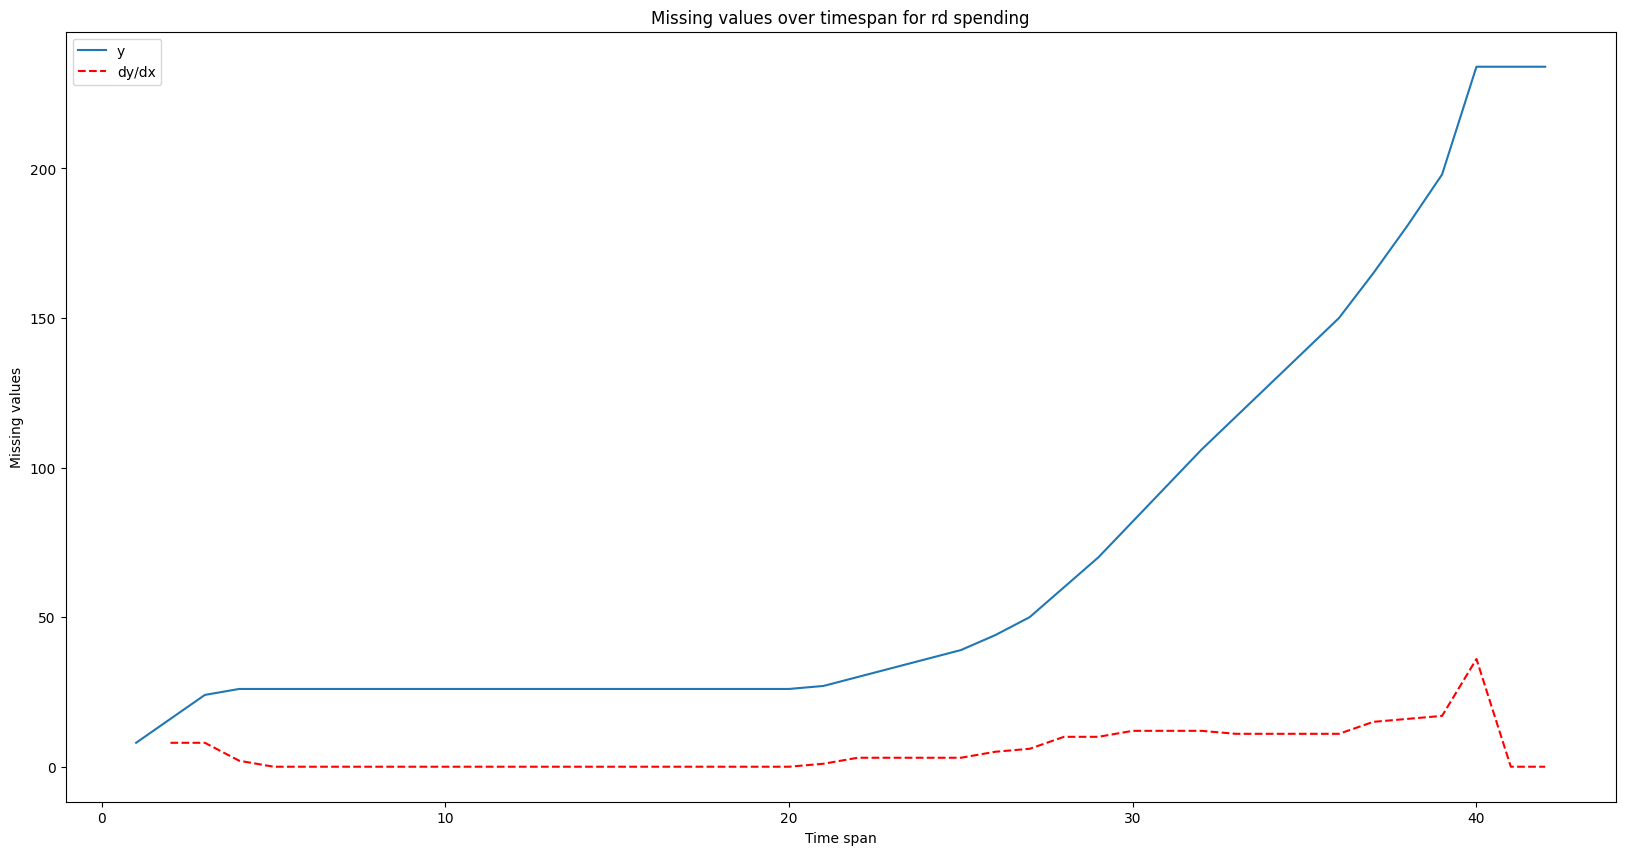

   x   y  y_total  rel_missing_values  dy/dx
0  1   8       48            0.166667    NaN
1  2  16       96            0.166667    8.0
2  3  24      144            0.166667    8.0
3  4  26      192            0.135417    2.0
4  5  26      240            0.108333    0.0


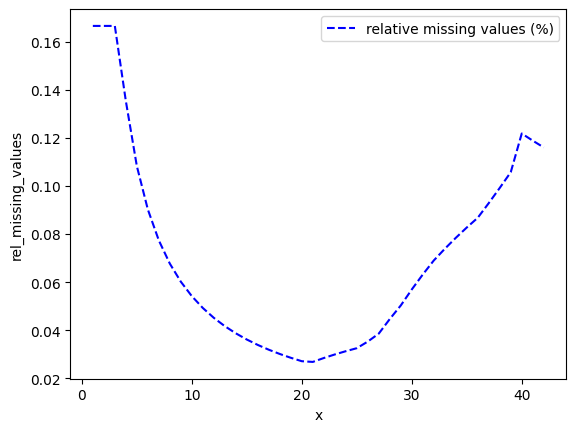

In [34]:
# print(PAT_APPLICATIONS_HIST.head())
unit = "P_MHAB"
sector = "Total"
filteredPatentApplications = PAT_APPLICATIONS_HIST[
    (PAT_APPLICATIONS_HIST["unit"] == unit)
]

print(filteredPatentApplications)


plotData = pd.DataFrame()
# add columns x and y
plotData["x"] = range(1, 43)
plotData["y"] = [
    sum(getMissingDataForTimespan(filteredPatentApplications, time_span).values())
    for time_span in range(1, 43)
]
# plotData["total_y"] = [sum(dataBySector.)]
plotData["y_total"] = [
    time_span * len(filteredPatentApplications["geo\TIME_PERIOD"].unique())
    for time_span in range(1, 43)
]
plotData["rel_missing_values"] = plotData["y"] / plotData["y_total"]


# Calculate the derivative (numerical approximation)
plotData["dy/dx"] = plotData["y"].diff()

# Plotting the data and its derivative
plt.figure(figsize=(20, 10))

# Plot the original data
sns.lineplot(data=plotData, x="x", y="y", label="y")

# Plot the derivative
sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)


plt.xlabel("Time span")
plt.ylabel("Missing values")
plt.title("Missing values over timespan for rd spending")
plt.legend()
plt.show()

print(plotData.head())
sns.lineplot(
    data=plotData,
    x="x",
    y="rel_missing_values",
    label="relative missing values (%)",
    linestyle="--",
    color="blue",
)
plt.show()

Similar results as R&D expenditures.

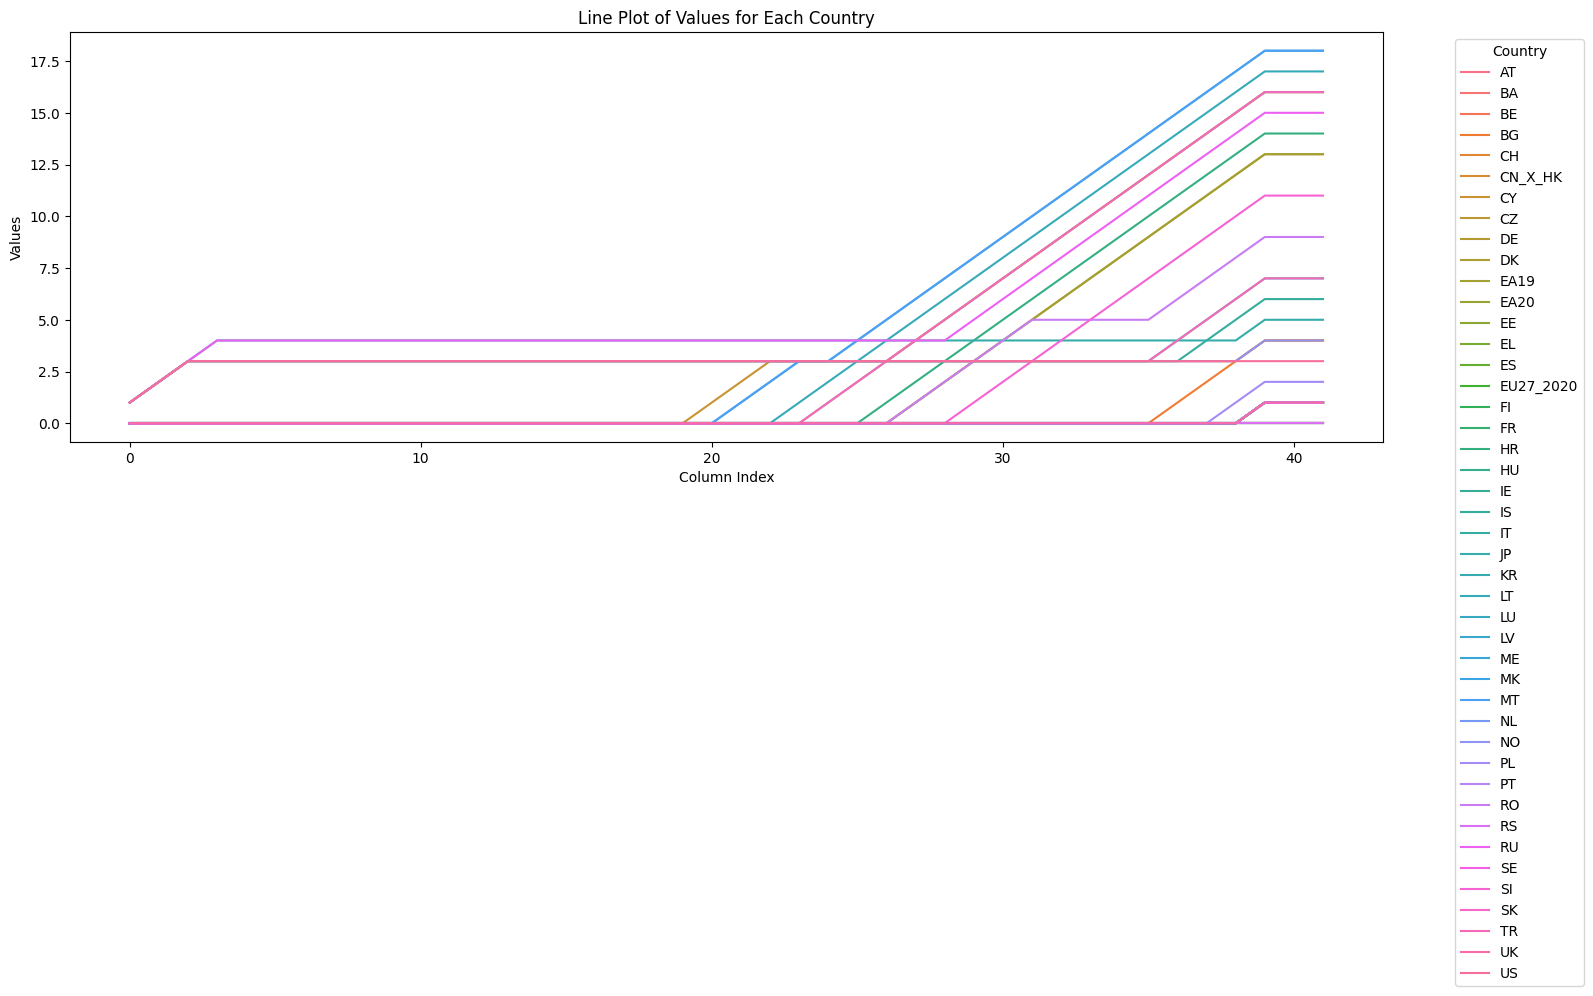

In [35]:
# print(dataBySector.head())

missingValuesPerCountryAndTimeSpan = pd.DataFrame(
    getMissingDataForTimespan(filteredPatentApplications, time_span, [])
    for time_span in range(1, 43)
)
missingValuesPerCountryAndTimeSpan = missingValuesPerCountryAndTimeSpan.T
# print(missingValuesPerCountryAndTimeSpan)

missingValuesPerCountryAndTimeSpan.reset_index(inplace=True)
missingValuesPerCountryAndTimeSpan.rename(columns={"index": "Country"}, inplace=True)


data_melted = missingValuesPerCountryAndTimeSpan.melt(
    id_vars="Country", var_name="Column", value_name="Value"
)

plt.figure(figsize=(16, 8))
sns.lineplot(data=data_melted, x="Column", y="Value", hue="Country")

# Customize plot
plt.title("Line Plot of Values for Each Country")
plt.xlabel("Column Index")
plt.ylabel("Values")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### Decisions on Patent Applications

Also here the most optimal range of values seems to be somewhat between 20 and 25 years in the past.


# Euurostat Data Preprocessing

Now, after we did some upfront analysis, we will continue with preparing a suitable dataset for further analysis.

## R&D spending

Let's start with the R&D spending.


In [36]:
sector = "TOTAL"
unit1 = "EUR_HAB"
unit2 = "PC_GDP"
year = 2024 - 25

# Filter Sector and units
RD_filtered = RD_EXP_BY_SECTOR[
    (RD_EXP_BY_SECTOR["sectperf"] == sector)
    & ((RD_EXP_BY_SECTOR["unit"] == unit1) | (RD_EXP_BY_SECTOR["unit"] == unit2))
]

# Drop unnecessary columns and rename columns
RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)

# Change to long format for further preprocessing
RD_long = RD_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
RD_long[["Year", "Indicator"]] = RD_long["Year_Indicator"].str.split("_", expand=True)
RD_long.drop(columns=["Year_Indicator"], inplace=True)
RD_long["Year"] = pd.to_numeric(RD_long["Year"])

# Filter to relevant time range
RD_long = RD_long[RD_long["Year"] >= year]


# Rename the different units
RD_long["Unit"].replace(
    {"EUR_HAB": "RD_spend_Euro_per_Inhabitant", "PC_GDP": "RD_spend_Percent_of_GDP"},
    inplace=True,
)

# RD_long.reset_index(drop=True, inplace=True)


# Separate value and flag in two columns
RD_long = RD_long.pivot_table(
    index=["Country", "Year", "Unit"],
    values="Value",
    columns="Indicator",
    aggfunc="first",
)

# Rename to capital letters
RD_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

# Convert value to numeric value for imputation
RD_long["Value"] = pd.to_numeric(RD_long["Value"])

# Reset index created by pivot
RD_long.reset_index(inplace=True)

# Remove Indicator title for columns
RD_long.columns.name = None

# RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)
display(RD_long)

<>:14: SyntaxWarning: invalid escape sequence '\T'
<>:14: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/956209663.py:14: SyntaxWarning: invalid escape sequence '\T'
  RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/tmp/ipykernel_125813/956209663.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.drop(columns=["freq", "sectperf"], inplace=True)
/tmp/ipykernel_125813/956209663.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RD_filtered.rename(columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True)
/tmp/ipykernel_125813/95620966

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
2195,US,2021,RD_spend_Percent_of_GDP,bd,3.480
2196,US,2022,RD_spend_Euro_per_Inhabitant,dp,2628.471
2197,US,2022,RD_spend_Percent_of_GDP,dp,3.590
2198,US,2023,RD_spend_Euro_per_Inhabitant,:,NaN


In [37]:
def plotFlatStruc(df, x, y, hue):
    plt.plot(df[x], df[y], marker="o", linestyle="-", color="b")
    plt.xticks(df[x], rotation=45)
    plt.show()

## Imputation of missing values using interpolation


,Country,Year,Unit,Flag,Value


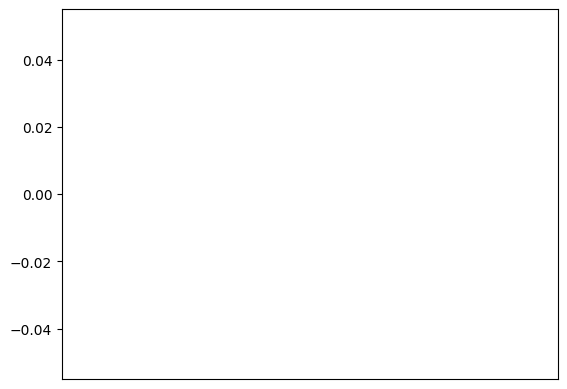

,Country,Year,Unit,Flag,Value


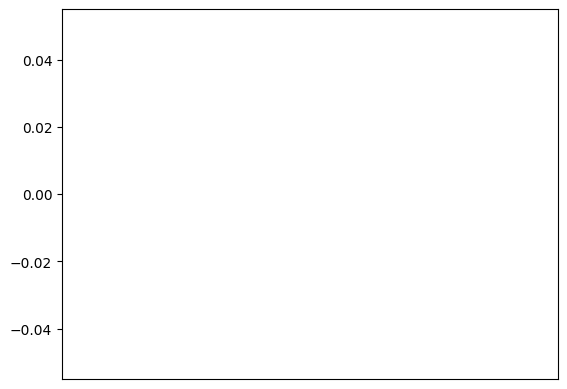

In [38]:
# Impute NaNs

country_to_test = "RU"
unit_to_test = "Percent_of_GDP"
# display(RD_long)

display(
    RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)]
)

plotFlatStruc(
    RD_long[
        (RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
)

RD_long["Value"] = RD_long.groupby(by=["Country", "Unit"])["Value"].transform(
    lambda group: group.interpolate(method="index")
)

display(
    RD_long[(RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)]
)

plotFlatStruc(
    RD_long[
        (RD_long["Unit"] == unit_to_test) & (RD_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
)

In [39]:
display(RD_long)

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
1,AT,1999,RD_spend_Percent_of_GDP,e,1.850
2,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
3,AT,2000,RD_spend_Percent_of_GDP,e,1.900
4,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
...,...,...,...,...,...
2195,US,2021,RD_spend_Percent_of_GDP,bd,3.480
2196,US,2022,RD_spend_Euro_per_Inhabitant,dp,2628.471
2197,US,2022,RD_spend_Percent_of_GDP,dp,3.590
2198,US,2023,RD_spend_Euro_per_Inhabitant,:,2628.471


## Preprocessing Patent Applications


## Historical Data (1999-2004)


In [40]:
unit1 = "P_MHAB"
# unit2 = "PC_GDP"
year = 2024 - 25

# Filter Sector and units
PAT_hist_filtered = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit1)]

# Drop unnecessary columns and rename columns
PAT_hist_filtered.drop(columns=["freq"], inplace=True)

PAT_hist_filtered.rename(
    columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
)

# #Change to long format for further preprocessing
PAT_hist_long = PAT_hist_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
PAT_hist_long[["Year", "Indicator"]] = PAT_hist_long["Year_Indicator"].str.split(
    "_", expand=True
)

PAT_hist_long.drop(columns=["Year_Indicator"], inplace=True)
PAT_hist_long["Year"] = pd.to_numeric(PAT_hist_long["Year"])

# Filter to relevant time range
PAT_hist_long = PAT_hist_long[
    (PAT_hist_long["Year"] >= year) & (PAT_hist_long["Year"] <= 2003)
]

# Rename the different units
PAT_hist_long["Unit"].replace(
    {"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True
)


display(PAT_hist_long)

<>:12: SyntaxWarning: invalid escape sequence '\T'
<>:12: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/2740712059.py:12: SyntaxWarning: invalid escape sequence '\T'
  columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
/tmp/ipykernel_125813/2740712059.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_hist_filtered.drop(columns=["freq"], inplace=True)
/tmp/ipykernel_125813/2740712059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_hist_filtered.rename(
/tmp/ipykernel_125813/2740712059.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series

,Country,Unit,Value,Year,Indicator
2016,AT,Pat_appl_per_million_inhabitants,134.33,1999,value
2017,AU,Pat_appl_per_million_inhabitants,51.5,1999,value
2018,BE,Pat_appl_per_million_inhabitants,131.63,1999,value
2019,BG,Pat_appl_per_million_inhabitants,0.97,1999,value
2020,BR,Pat_appl_per_million_inhabitants,0.74,1999,value
...,...,...,...,...,...
2491,SK,Pat_appl_per_million_inhabitants,,2003,flag
2492,TR,Pat_appl_per_million_inhabitants,,2003,flag
2493,UK,Pat_appl_per_million_inhabitants,,2003,flag
2494,US,Pat_appl_per_million_inhabitants,,2003,flag


## New Data (2004 - 2023)


In [41]:
unit1 = "P_MHAB"
coop = "APPL"

# Filter Sector and units
PAT_new_filtered = PAT_APPLICATIONS_NEW[
    (PAT_APPLICATIONS_NEW["unit"] == unit1) & (PAT_APPLICATIONS_NEW["coop_ptn"] == coop)
]

# Drop unnecessary columns and rename columns
PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)

PAT_new_filtered.rename(
    columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
)

# #Change to long format for further preprocessing
PAT_new_long = PAT_new_filtered.melt(
    id_vars=["Country", "Unit"], var_name="Year_Indicator", value_name="Value"
)

# Split year and indicator
PAT_new_long[["Year", "Indicator"]] = PAT_new_long["Year_Indicator"].str.split(
    "_", expand=True
)

PAT_new_long.drop(columns=["Year_Indicator"], inplace=True)


PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])

# Filter to relevant time range
PAT_new_long = PAT_new_long[(PAT_new_long["Year"] >= 2004)]

# Rename the different units
PAT_new_long["Unit"].replace(
    {"P_MHAB": "Pat_appl_per_million_inhabitants"}, inplace=True
)

display(PAT_new_long)

<>:13: SyntaxWarning: invalid escape sequence '\T'
<>:13: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_125813/913015078.py:13: SyntaxWarning: invalid escape sequence '\T'
  columns={"geo\TIME_PERIOD": "Country", "unit": "Unit"}, inplace=True
/tmp/ipykernel_125813/913015078.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_new_filtered.drop(columns=["freq", "coop_ptn"], inplace=True)
/tmp/ipykernel_125813/913015078.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PAT_new_filtered.rename(
/tmp/ipykernel_125813/913015078.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or

,Country,Unit,Value,Year,Indicator
0,AL,Pat_appl_per_million_inhabitants,NaN,2004,value
1,AT,Pat_appl_per_million_inhabitants,122.37,2004,value
2,BA,Pat_appl_per_million_inhabitants,NaN,2004,value
3,BE,Pat_appl_per_million_inhabitants,143.27,2004,value
4,BG,Pat_appl_per_million_inhabitants,2.07,2004,value
...,...,...,...,...,...
1515,RS,Pat_appl_per_million_inhabitants,bp,2023,flag
1516,SE,Pat_appl_per_million_inhabitants,p,2023,flag
1517,SI,Pat_appl_per_million_inhabitants,p,2023,flag
1518,SK,Pat_appl_per_million_inhabitants,p,2023,flag


## Combinining Historical and Current


In [42]:
PAT_comb_long = pd.concat([PAT_hist_long, PAT_new_long], axis=0)
PAT_comb_long.reset_index(drop=True, inplace=True)


# Separate value and flag in two columns
PAT_comb_long = PAT_comb_long.pivot_table(
    index=["Country", "Year", "Unit"],
    values="Value",
    columns="Indicator",
    aggfunc="first",
)


# Rename to capital letters
PAT_comb_long.rename(columns={"value": "Value", "flag": "Flag"}, inplace=True)

# Convert value to numeric value for imputation
PAT_comb_long["Value"] = pd.to_numeric(PAT_comb_long["Value"])

# Reset index created by pivot
PAT_comb_long.reset_index(inplace=True)

# Remove Indicator title for columns
PAT_comb_long.columns.name = None

PAT_new_long["Year"] = pd.to_numeric(PAT_new_long["Year"])


# RD_long.set_index(['Country', 'Year', 'Unit'], inplace=True)

display(PAT_comb_long)

,Country,Year,Unit,Flag,Value
0,AL,2004,Pat_appl_per_million_inhabitants,:,NaN
1,AL,2005,Pat_appl_per_million_inhabitants,:,NaN
2,AL,2006,Pat_appl_per_million_inhabitants,:,NaN
3,AL,2007,Pat_appl_per_million_inhabitants,:,NaN
4,AL,2008,Pat_appl_per_million_inhabitants,:,NaN
...,...,...,...,...,...
995,ZA,1999,Pat_appl_per_million_inhabitants,,3.15
996,ZA,2000,Pat_appl_per_million_inhabitants,,3.28
997,ZA,2001,Pat_appl_per_million_inhabitants,,2.66
998,ZA,2002,Pat_appl_per_million_inhabitants,,2.86


## Imputation of missing Values


,Country,Year,Unit,Flag,Value
50,BA,2004,Pat_appl_per_million_inhabitants,:,NaN
51,BA,2005,Pat_appl_per_million_inhabitants,:,NaN
52,BA,2006,Pat_appl_per_million_inhabitants,:,NaN
53,BA,2007,Pat_appl_per_million_inhabitants,:,NaN
54,BA,2008,Pat_appl_per_million_inhabitants,:,NaN
55,BA,2009,Pat_appl_per_million_inhabitants,,0.26
56,BA,2010,Pat_appl_per_million_inhabitants,,0.52
57,BA,2011,Pat_appl_per_million_inhabitants,,0.00
58,BA,2012,Pat_appl_per_million_inhabitants,,0.78
59,BA,2013,Pat_appl_per_million_inhabitants,,0.26


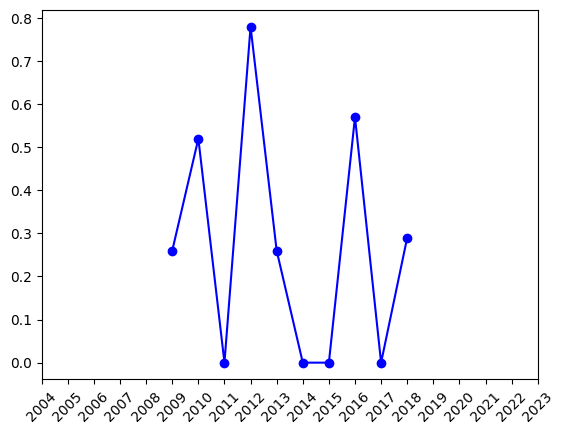

,Country,Year,Unit,Flag,Value
50,BA,2004,Pat_appl_per_million_inhabitants,:,NaN
51,BA,2005,Pat_appl_per_million_inhabitants,:,NaN
52,BA,2006,Pat_appl_per_million_inhabitants,:,NaN
53,BA,2007,Pat_appl_per_million_inhabitants,:,NaN
54,BA,2008,Pat_appl_per_million_inhabitants,:,NaN
55,BA,2009,Pat_appl_per_million_inhabitants,,0.26
56,BA,2010,Pat_appl_per_million_inhabitants,,0.52
57,BA,2011,Pat_appl_per_million_inhabitants,,0.00
58,BA,2012,Pat_appl_per_million_inhabitants,,0.78
59,BA,2013,Pat_appl_per_million_inhabitants,,0.26


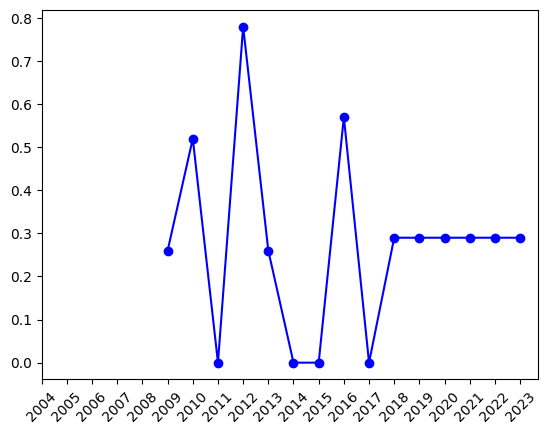

In [43]:
# Impute NaNs

country_to_test = "BA"
unit_to_test = "Pat_appl_per_million_inhabitants"

display(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ]
)

plotFlatStruc(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
)

PAT_comb_long["Value"] = PAT_comb_long.groupby(by=["Country", "Unit"])[
    "Value"
].transform(lambda group: group.interpolate(method="index"))

display(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ]
)

plotFlatStruc(
    PAT_comb_long[
        (PAT_comb_long["Unit"] == unit_to_test)
        & (PAT_comb_long["Country"] == country_to_test)
    ],
    x="Year",
    y="Value",
    hue="Country",
)

## Merge RD and Patent Data

Now we combine the RD expenditure and patentt application dataset into on merged df.

In [44]:
merged_df = pd.concat([RD_long, PAT_comb_long], axis=0)
merged_df.reset_index(drop=True, inplace=True)
merged_df.sort_values(by=["Country", "Year", "Unit"], inplace=True)

merged_df.set_index(["Country", "Year", "Unit"], inplace=True)
display(merged_df)

Flag  Value
Country Year Unit                                        
AL      2004 Pat_appl_per_million_inhabitants    :    NaN
        2005 Pat_appl_per_million_inhabitants    :    NaN
        2006 Pat_appl_per_million_inhabitants    :    NaN
        2007 Pat_appl_per_million_inhabitants    :    NaN
        2008 Pat_appl_per_million_inhabitants    :    NaN
...                                            ...    ...
ZA      1999 Pat_appl_per_million_inhabitants        3.15
        2000 Pat_appl_per_million_inhabitants        3.28
        2001 Pat_appl_per_million_inhabitants        2.66
        2002 Pat_appl_per_million_inhabitants        2.86
        2003 Pat_appl_per_million_inhabitants        3.19

[3200 rows x 2 columns]

Looks like for a time span sub 20-30 years, the data has not too many missing values. Also the number of missing values starts to increase after a time span of ca 23 years.


Do the same for the patent dataset, and see if the same pattern is observed.


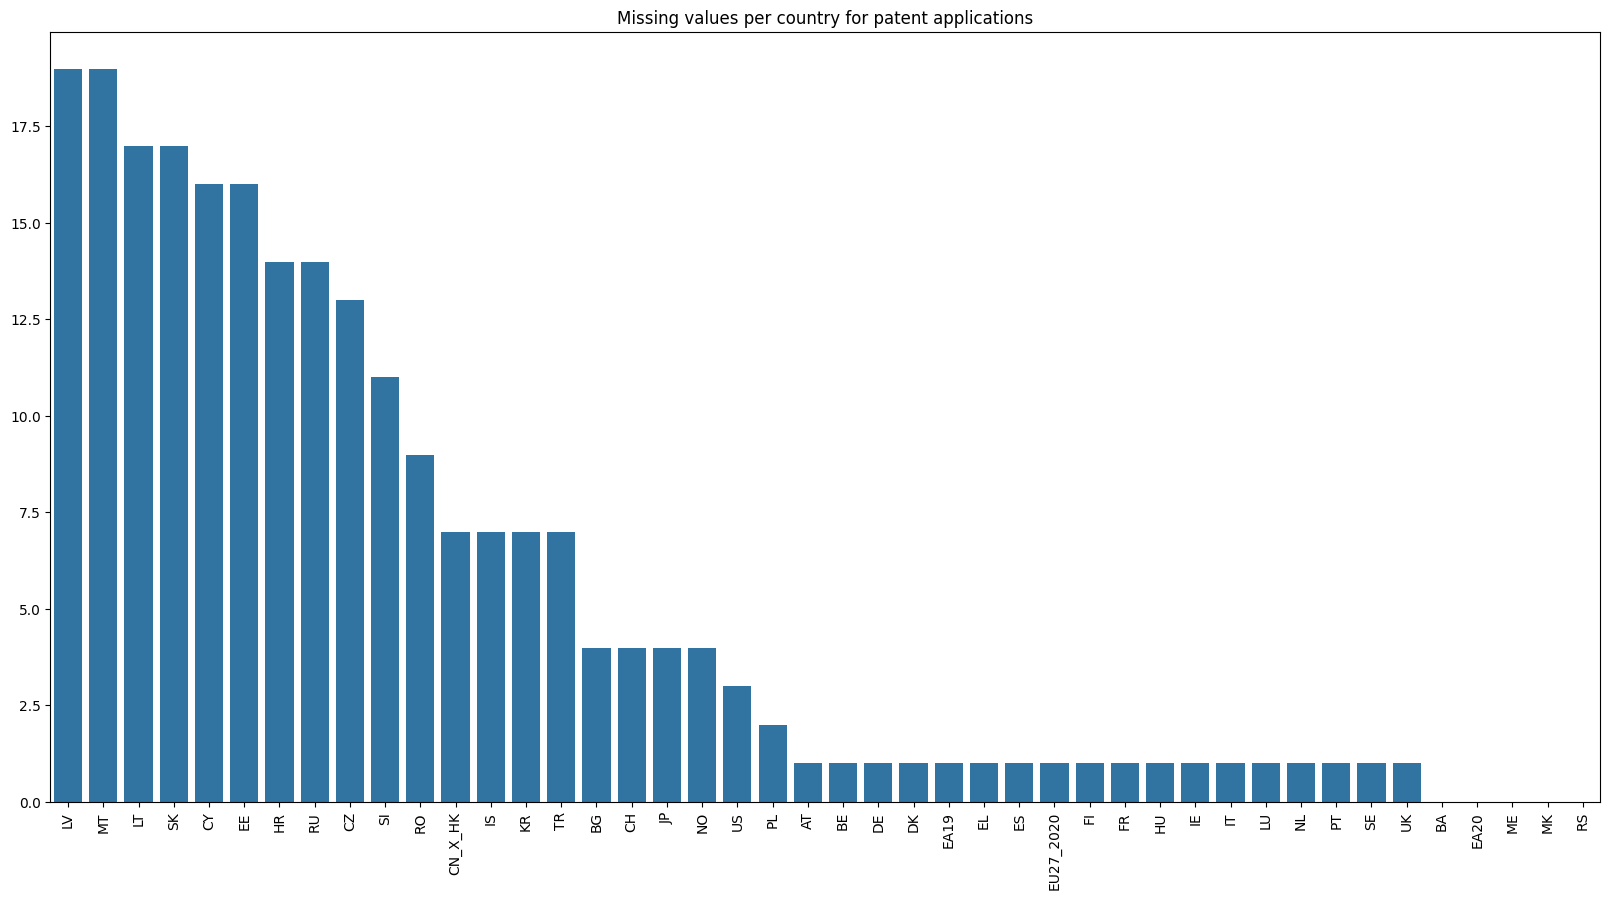

In [45]:
time_span = 43
unit = "NR"  # should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

missingData = getMissingDataForTimespan(data, time_span, [])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()

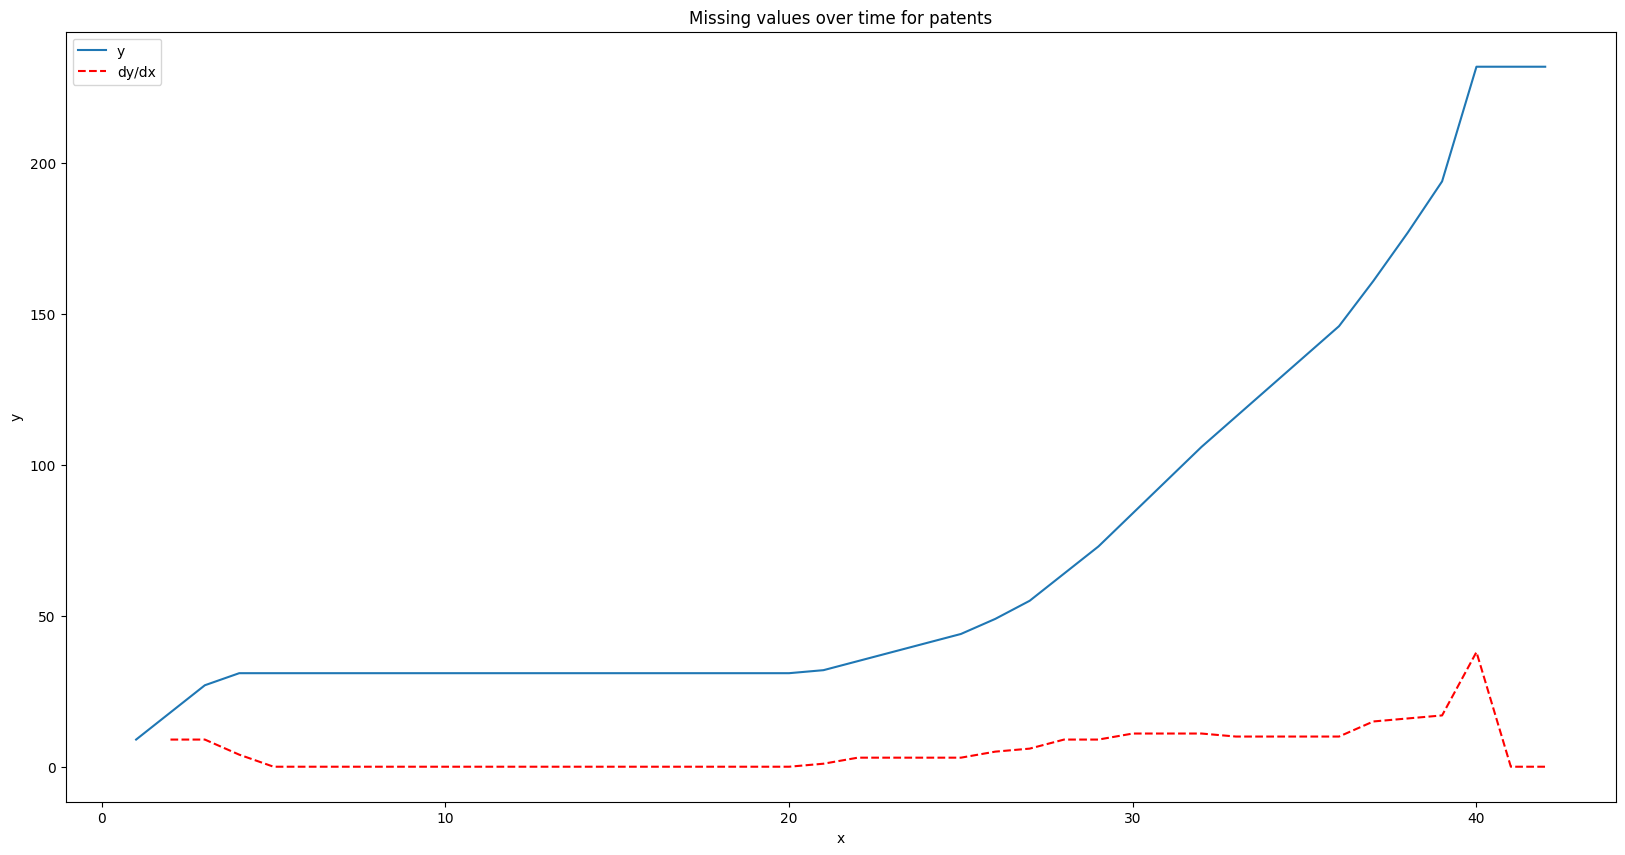

In [46]:
import pandas as pd



plotData = pd.DataFrame()


# add columns x and y


plotData["x"] = range(1, 43)


plotData["y"] = [
    sum(getMissingDataForTimespan(data, time_span, []).values())
    for time_span in range(1, 43)
]



# Calculate the derivative (numerical approximation)


plotData["dy/dx"] = plotData["y"].diff()



# Plotting the data and its derivative


plt.figure(figsize=(20, 10))



# Plot the original data


sns.lineplot(data=plotData, x="x", y="y", label="y")



# Plot the derivative


sns.lineplot(
    data=plotData, x="x", y="dy/dx", label="dy/dx", linestyle="--", color="red"
)


plt.title("Missing values over time for patents")
plt.legend()


plt.show()

Looks like the patent dataset as good data for the last 20-25 years.


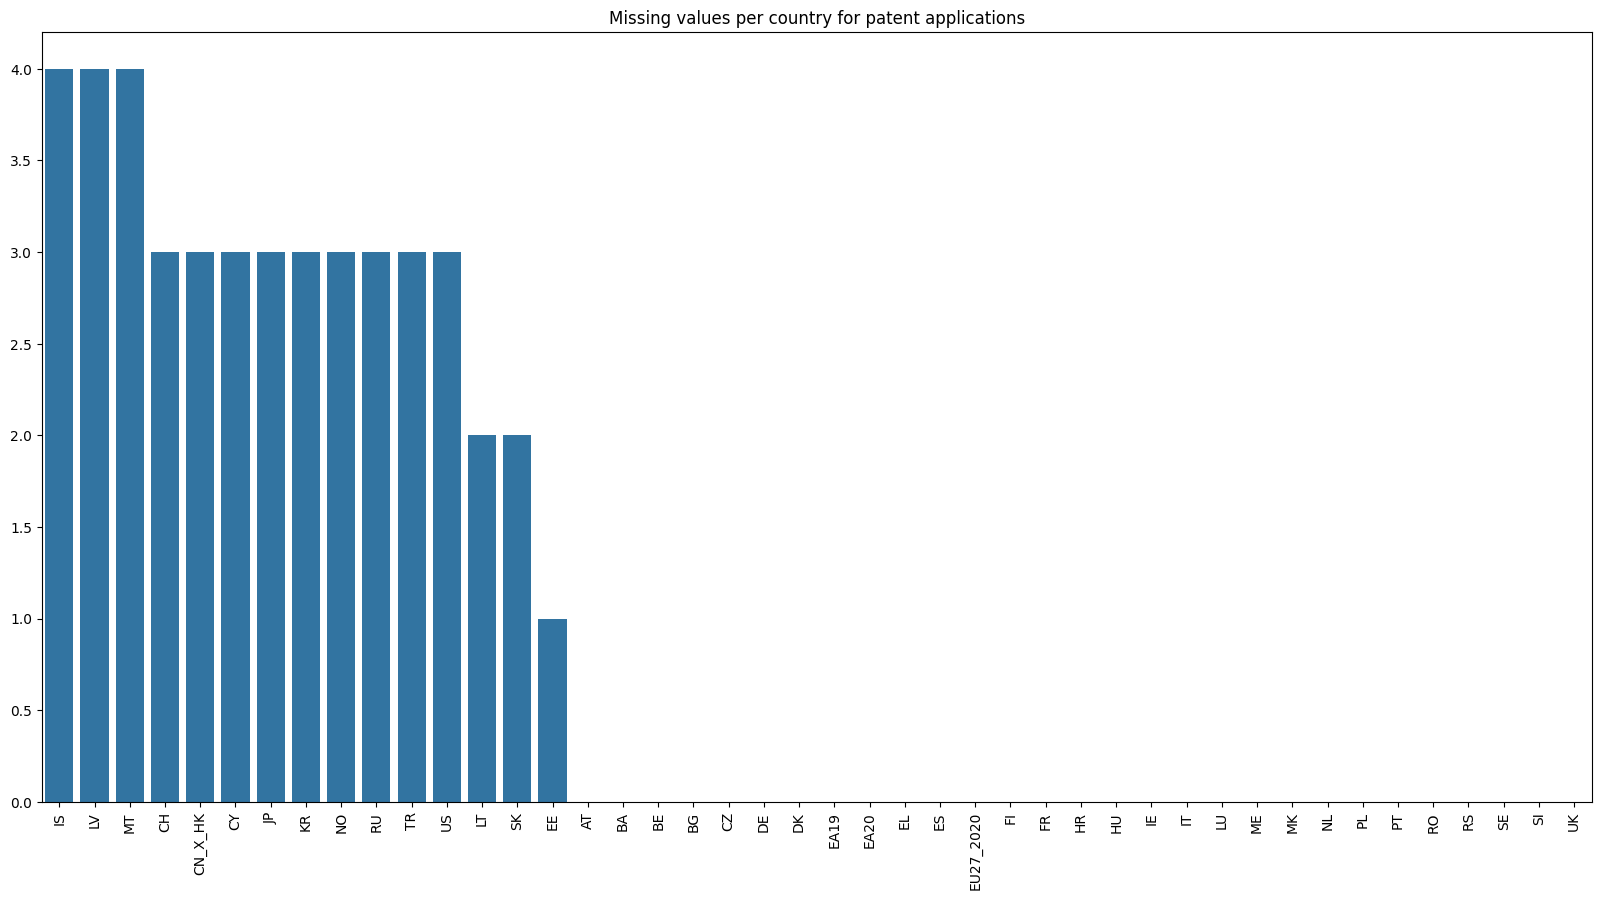

In [47]:
time_span = 25
unit = "NR"  # should be enough since we already cleaned the rnd spending data according to inhabitants
data = PAT_APPLICATIONS_HIST[(PAT_APPLICATIONS_HIST["unit"] == unit)]

missingData = getMissingDataForTimespan(data, time_span, [])

missingData = dict(sorted(missingData.items(), key=lambda item: item[1], reverse=True))
plt.figure(figsize=(20, 10))
sns.barplot(x=missingData.keys(), y=missingData.values())
plt.xticks(rotation=90)
plt.title("Missing values per country for patent applications")
plt.show()

## Merge Eurostat and GII Data

In this step we merge the preprocess Eurostat data with the GII data. This will allow us to compare the GII data with other indicators.

In [48]:
country_abbreviations = {
    'Albania': 'AL', 'Austria': 'AT', 'Belarus': 'BY', 'Belgium': 'BE', 
    'Bosnia and Herzegovina': 'BA', 'Bulgaria': 'BG', 'Croatia': 'HR', 
    'Czech Republic': 'CZ', 'Denmark': 'DK', 'Estonia': 'EE', 
    'Finland': 'FI', 'France': 'FR', 'Germany': 'DE', 'Greece': 'EL', 
    'Hungary': 'HU', 'Iceland': 'IS', 'Ireland': 'IE', 'Italy': 'IT', 
    'Latvia': 'LV', 'Lithuania': 'LT', 'Luxembourg': 'LU', 'Malta': 'MT', 
    'Montenegro': 'ME', 'Netherlands': 'NL', 'North Macedonia': 'MK', 
    'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 
    'Republic of Moldova': 'MD', 'Romania': 'RO', 'Russian Federation': 'RU', 
    'Serbia': 'RS', 'Slovakia': 'SK', 'Slovenia': 'SI', 'Spain': 'ES', 
    'Sweden': 'SE', 'Switzerland': 'CH', 'Ukraine': 'UA', 
    'United Kingdom': 'UK'
}

In [49]:

GII_2023_prepared['Country'] = GII_2023_prepared.index.map(country_abbreviations)

#display(GII_2023_prepared)
print(merged_df)
merged_df.reset_index(inplace=True)
merged_df_relevant = merged_df[(merged_df["Year"] == 2023) & (merged_df["Unit"] == "RD_spend_Euro_per_Inhabitant")]
result = pd.merge(merged_df_relevant, GII_2023_prepared, on=["Country", "Country"], how='inner')

result = result[['Country', 'Year', 'Value', 'Final']]
result.rename(columns={"Value": "RD_spend_Euro_per_Inhabitant"}, inplace=True)
result.set_index(['Country', 'Year'], inplace=True)

display(result)
print(result.corr())

#TODO: vielleicht noch andere Jahre ansehen und verschönern (Code)

                                              Flag  Value
Country Year Unit                                        
AL      2004 Pat_appl_per_million_inhabitants    :    NaN
        2005 Pat_appl_per_million_inhabitants    :    NaN
        2006 Pat_appl_per_million_inhabitants    :    NaN
        2007 Pat_appl_per_million_inhabitants    :    NaN
        2008 Pat_appl_per_million_inhabitants    :    NaN
...                                            ...    ...
ZA      1999 Pat_appl_per_million_inhabitants        3.15
        2000 Pat_appl_per_million_inhabitants        3.28
        2001 Pat_appl_per_million_inhabitants        2.66
        2002 Pat_appl_per_million_inhabitants        2.86
        2003 Pat_appl_per_million_inhabitants        3.19

[3200 rows x 2 columns]


/tmp/ipykernel_125813/1735270163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GII_2023_prepared['Country'] = GII_2023_prepared.index.map(country_abbreviations)


,,RD_spend_Euro_per_Inhabitant,Final
Country,Year,,
AT,2023,1711.235,53.247123
BA,2023,9.923,27.148722
BE,2023,1687.640,49.943794
BG,2023,116.371,38.983933
CH,2023,2622.067,67.588814
CZ,2023,537.506,44.833748
DE,2023,1540.704,58.755365
DK,2023,1894.514,58.733405
EE,2023,514.091,53.376560


                              RD_spend_Euro_per_Inhabitant     Final
RD_spend_Euro_per_Inhabitant                      1.000000  0.826126
Final                                             0.826126  1.000000


In [50]:
RD_spending = merged_df[(merged_df["Unit"] == "RD_spend_Euro_per_Inhabitant")]
#RD_spending.drop(columns=["level_0", "index"], inplace=True)
display(RD_spending)

,Country,Year,Unit,Flag,Value
21,AT,1999,RD_spend_Euro_per_Inhabitant,e,471.258
24,AT,2000,RD_spend_Euro_per_Inhabitant,e,503.446
27,AT,2001,RD_spend_Euro_per_Inhabitant,e,547.702
30,AT,2002,RD_spend_Euro_per_Inhabitant,,580.918
33,AT,2003,RD_spend_Euro_per_Inhabitant,e,622.446
...,...,...,...,...,...
3185,US,2019,RD_spend_Euro_per_Inhabitant,d,1830.457
3187,US,2020,RD_spend_Euro_per_Inhabitant,d,1926.849
3189,US,2021,RD_spend_Euro_per_Inhabitant,bd,2090.641
3191,US,2022,RD_spend_Euro_per_Inhabitant,dp,2628.471


# Predicting future R&D expenditure

In this step we try to train a ARIMA model to predict fuuture R&D expenditure.



In [51]:
from statsmodels.tsa.arima.model import ARIMA

forecasts = []

for country, group in RD_spending.groupby('Country'):
    begyear = max(group['Year'])
    model = ARIMA(group['Value'], order=(5, 1, 0))
    model_fit = model.fit()
    pred = model_fit.forecast(steps=3)
    forecasts.append({'Country': country, 'Year': begyear+1, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[0]})
    forecasts.append({'Country': country, 'Year': begyear+2, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[1]})
    forecasts.append({'Country': country, 'Year': begyear+3, 'Unit': 'RD_spend_Euro_per_Inhabitant', 'Flag': 'predicted', 'Value': pred.iloc[2]})

RD_spending_temp = RD_spending
RD_spending_temp["Flag"] = "data"
RD_spending_forecast = pd.concat([RD_spending_temp, pd.DataFrame(forecasts)], ignore_index=True)
RD_spending_forecast.sort_values(by= ["Country", "Year"], inplace=True)
display(RD_spending_forecast)

/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/tuw/dopp/project/DOPP_WS24/.venv/lib64/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/vinz/Documents/t

,Country,Year,Unit,Flag,Value
0,AT,1999,RD_spend_Euro_per_Inhabitant,data,471.258000
1,AT,2000,RD_spend_Euro_per_Inhabitant,data,503.446000
2,AT,2001,RD_spend_Euro_per_Inhabitant,data,547.702000
3,AT,2002,RD_spend_Euro_per_Inhabitant,data,580.918000
4,AT,2003,RD_spend_Euro_per_Inhabitant,data,622.446000
...,...,...,...,...,...
1098,US,2022,RD_spend_Euro_per_Inhabitant,data,2628.471000
1099,US,2023,RD_spend_Euro_per_Inhabitant,data,2628.471000
1229,US,2024,RD_spend_Euro_per_Inhabitant,predicted,2692.228199
1230,US,2025,RD_spend_Euro_per_Inhabitant,predicted,2989.742006


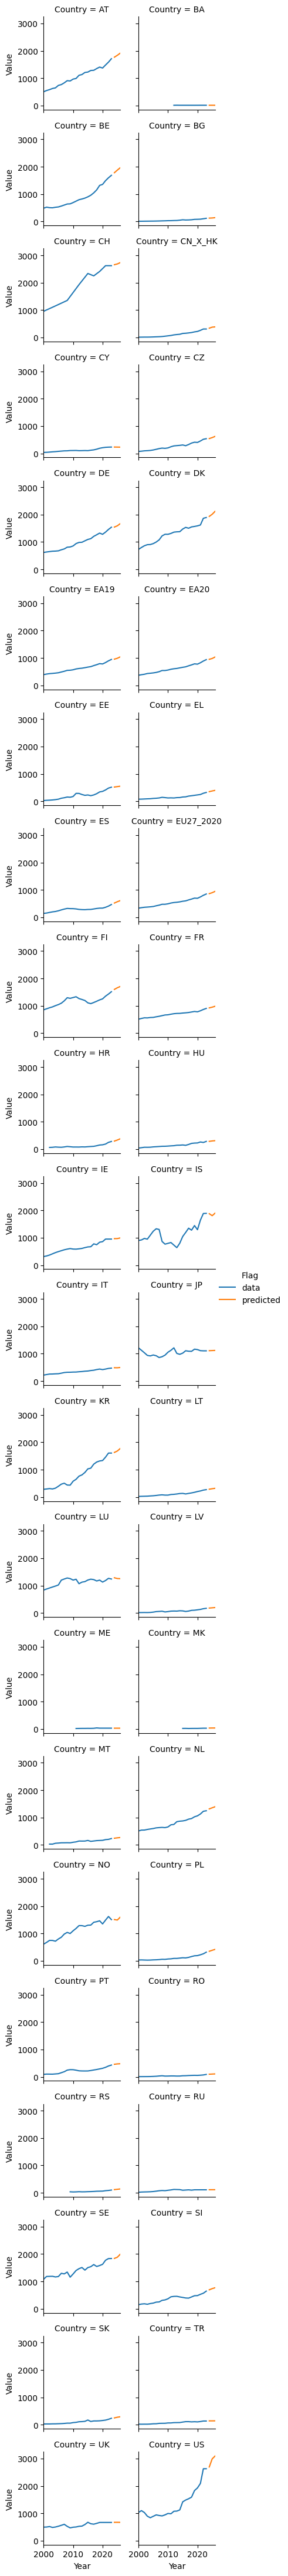

In [52]:
g = sns.FacetGrid(RD_spending_forecast, col="Country", hue="Flag", col_wrap=2, height=2, xlim=(2000, 2026))
g.map(sns.lineplot, "Year", "Value")
g.add_legend()

#TODO: Farbliche Darstellung der PRediction? generell GRaphs aufbereiten.

# Load Historical GII Data
Found a dataset with historical GII data. Let's load it and see if we can use it for our analysis.
https://data.mendeley.com/datasets/cvkdzr8tv3/4

In [53]:
import pandas as pd
# file name ../data/GII_historical.xlsx
# sheet Scores has the relevant data
# Current format: Economies (Column A),Year (Column B),Global Innovation Index (Column K)
# Load it into a pandas dataframe
# Transpute as following the rows are the economies, the columns are the years and the values are the GII

import pycountry

# Function to get ISO 3 country code
def get_iso3(country_name):
    
    custom_iso3 = {
    "Bolivia (Plurinational State of)": "BOL",
    "Iran (Islamic Republic of)": "IRN",
    "Republic of Moldova (the)": "MDA",
    "United States of America": "USA",
    "Venezuela, Bolivarian Republic of": "VEN",
    "North Macedonia*": "MKD",
    "United Republic of Tanzania (the)": "TZA",
    "Hong Kong (China)": "HKG",
    "Republic of Korea (the)": "KOR",
    "Vietnam": "VNM",
    "Czech Republic": "CZE",
    "Cote dIvoire": "CIV"
}

    
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3 if country else custom_iso3.get(country_name, country_name)  # Return code or original name if not found
    except KeyError:
        print(f"Country not found: {country_name}")
        return custom_iso3.get(country_name, country_name)


filename = "../data/GII_historical.xlsx"
GII_historical = pd.read_excel(filename, sheet_name="Scores")
# Update 'Economies' column to use ISO 3 codes
GII_historical["Economies"] = GII_historical["Economies"].apply(get_iso3)
#rename the Economies column to ISO3
GII_historical.rename(columns={"Economies": "ISO3"}, inplace=True)
GII_historical = GII_historical.set_index("ISO3")
GII_historical = GII_historical.pivot(columns="Year", values="Global Innovation Index")
GII_historical.columns = GII_historical.columns.astype(int)

#drop na if >4
GII_historical = GII_historical[GII_historical.isna().sum(axis=1) <= 4]


GII_melted = GII_historical.reset_index().melt(
    id_vars="ISO3", var_name="Year", value_name="Global Innovation Index"
)

# Replace the country names withh the ISO3 codes
#GII_historical["Economies"] = GII_historical.index.map(country_abbreviations)
#GII_melted.head()


GII_historical.head()


Year,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ISO3,,,,,,,,,,,,
ALB,30.45,30.4,30.9,30.5,30.7,28.4,28.9,30.0,30.3,27.1,28.0,24.4
ARE,41.99,44.4,41.9,43.2,40.1,39.4,43.2,42.6,42.2,41.8,43.0,42.1
ARG,35.36,34.4,37.7,35.1,34.3,30.2,32.0,30.7,31.9,28.3,29.8,28.6
ARM,33.00,34.5,37.6,36.1,37.3,35.1,35.7,32.8,34.0,32.6,31.4,26.6
AUS,49.85,51.9,53.1,55.0,55.2,53.1,51.8,52.0,50.3,48.4,48.3,47.1


In [54]:
# For each row / country in the GII_historical dataframe plot the GII over the years
# The x-axis should be the years and the y-axis the GII
# The color of the line should be the country
# The title should be the country
# The x-axis label should be the years

import matplotlib.pyplot as plt
import seaborn as sns

# g = sns.FacetGrid(GII_melted, col="ISO3", col_wrap=4, height=3, sharey=False)
# g.map(sns.lineplot, "Year", "Global Innovation Index", marker="o")

# # Customize the plot
# g.set_titles("{col_name}")
# g.set_axis_labels("Year", "GII")
# g.set_xticklabels(rotation=45)
# g.tight_layout()
# plt.show()


## Calculate Dervatives

Next we calculate the derivatives of the GII data to see if we can find some interesting patterns. Maybe with those we can predict future innovation levels.

In [55]:
# Calculate first and second derivatives
derivatives = GII_historical.copy()

# First derivative (rate of change)
first_derivative = derivatives.diff(axis=1)
print(first_derivative.head())

# Second derivative (acceleration)
second_derivative = first_derivative.diff(axis=1)
print(second_derivative.head())



Year  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  2021  2022
ISO3                                                                        
ALB    NaN -0.05   0.5  -0.4   0.2  -2.3   0.5   1.1   0.3  -3.2   0.9  -3.6
ARE    NaN  2.41  -2.5   1.3  -3.1  -0.7   3.8  -0.6  -0.4  -0.4   1.2  -0.9
ARG    NaN -0.96   3.3  -2.6  -0.8  -4.1   1.8  -1.3   1.2  -3.6   1.5  -1.2
ARM    NaN  1.50   3.1  -1.5   1.2  -2.2   0.6  -2.9   1.2  -1.4  -1.2  -4.8
AUS    NaN  2.05   1.2   1.9   0.2  -2.1  -1.3   0.2  -1.7  -1.9  -0.1  -1.2
Year  2011  2012  2013  2014  2015  2016  2017  2018  2019          2020  \
ISO3                                                                       
ALB    NaN   NaN  0.55  -0.9   0.6  -2.5   2.8   0.6  -0.8 -3.500000e+00   
ARE    NaN   NaN -4.91   3.8  -4.4   2.4   4.5  -4.4   0.2 -7.105427e-15   
ARG    NaN   NaN  4.26  -5.9   1.8  -3.3   5.9  -3.1   2.5 -4.800000e+00   
ARM    NaN   NaN  1.60  -4.6   2.7  -3.4   2.8  -3.5   4.1 -2.600000e+00   
AUS  

In [56]:

gii_data_2023 = get_europe(GII_2023)

#print the column ISO3 and SCORE where the column NUM is null
pure_rank = gii_data_2023[gii_data_2023["NUM"].isnull()]
#do not display the rank only the score and ISO3
gii_scores_2023 = pure_rank.sort_values("SCORE")[["SCORE", "ISO3"]]
#rename SCORE to 2023
gii_scores_2023.rename(columns={"SCORE": "2023"}, inplace=True)
print(gii_scores_2023.head())

            2023 ISO3
0      25.426758  ALB
1110   26.843908  BLR
1554   27.148722  BIH
8658   27.796063  MNE
11100  30.333934  MDA


## Trying to predict a trend of the GII scores with the help of the derivatives

Following the idea of the previous section, we will now try to build a simple model using only the derivatives of the GII data. We will see if we can predict future innovation levels with this model.

In [57]:
# now for each country we have the first and second derivative of the GII for the years 2011 to 2022
# we also got the GII scores for thhe year 2023
# now we can do following predictions if the first derivative is positive and the second derivative is negative
# the GII will still increase but at a slower rate
# if the first derivative is negative and the second derivative is positive the GII will decrease but at a slower rate
# if the first derivative is positive and the second derivative is positive the GII will increase at an increasing rate
# if the first derivative is negative and the second derivative is negative the GII will decrease at an increasing rate
# if the first derivative is positive and the second derivative is zero the GII will increase at a constant rate
# if the first derivative is negative and the second derivative is zero the GII will decrease at a constant rate
# if the first derivative is close to zero the GII will stay constant

# we got following dataframes 
# gii_scores_2023 , columns ISO3 and SCORE
# first_derivative, columns are the years, the rows are the countries
# second_derivative, columns are the years, the rows are the countries

# now we can calculate the predictions for the year 2023 and compare them with the actual scores
# the prediicitons are in following format. IO3, Increases/Decreases/Constant, Slower/Faster, Scorefrom 2022, Score from 2023, TRUE/FALSE IF CORRECT
gii_scores_2022 = GII_historical[2022]  
#print(gii_scores_2022)
gii_scores = pd.merge(gii_scores_2022, gii_scores_2023, on='ISO3', suffixes=('_2022', '_2023'))
gii_scores.set_index('ISO3', inplace=True)
#print(gii_scores)
results = []
for iso3 in gii_scores.index:
    # Extract derivatives for 2022
    try:
        fd = first_derivative.loc[iso3, 2022]
        sd = second_derivative.loc[iso3, 2022]
    except KeyError:
        print(f"Derivatives not available for {iso3}")
        continue
    
    # Determine trend and rate
    trend = "Constant"
    rate = "Constant"
    
    epsilon = 1  # Threshold for considering zero
    
    if abs(fd) < epsilon:
        trend = "Constant"
        rate = ""  # Rate not applicable if constant
    else:
        if fd > 0:
            trend = "Increases"
            if sd < -epsilon:
                rate = "Slower"
            elif sd > epsilon:
                rate = "Faster"
            else:
                rate = "Constant"
        else:
            trend = "Decreases"
            if sd > epsilon:
                rate = "Slower"
            elif sd < -epsilon:
                rate = "Faster"
            else:
                rate = "Constant"
    
    # Retrieve actual scores for 2022 and 2023
    score_row = gii_scores.loc[iso3]
    if score_row.empty:
        score_2022 = None
        score_2023 = None
    else:
        score_2022 = score_row.values[0]
        score_2023 = score_row.values[1]
        #round score_2023 to 1 decimal places   
        score_2023 = round(score_2023, 1)
    
    # Determine actual trend
    actual_trend = "Constant"
    if score_2022 is not None and score_2023 is not None:
        # Calculate the absolute difference between 2023 and 2022 scores
        difference = abs(score_2023 - score_2022)
        
        # Determine the trend based on the difference
        if difference <= 1:
            actual_trend = "Constant"
        elif score_2023 > score_2022:
            actual_trend = "Increases"
        else:
            actual_trend = "Decreases"
    
    # Check if prediction is correct
    correct = False
    if trend == "Constant":
        correct = (actual_trend == "Constant")
    else:
        correct = (trend == actual_trend)
        dumbPrediction = ("Increases" == actual_trend)
    
    #print(iso3, trend, rate, score_2022, score_2023, correct)
    # Append the result
    results.append({
        'ISO3': iso3,
        'Predicted Trend': trend,
        'first_derivative': fd,
        'second_derivative': sd,
        'Predicted Rate': rate,
        'Score 2022': score_2022,
        'Score 2023': score_2023,
        'Correct Prediction': correct,
        'Dumb Prediction': dumbPrediction
    })

# Create the results DataFrame
results_df = pd.DataFrame(results)
#display(results_df)
# calculate the accuracy of the predictions
accuracy = results_df["Correct Prediction"].mean()
print(f"Accuracy actual: {accuracy:.2f}")  

# calculate the accuracy of the dumb predictions
# where just the GII increases
accuracy = results_df["Dumb Prediction"].mean()
print(f"Accuracy dumb: {accuracy:.2f}")


Accuracy actual: 0.13
Accuracy dumb: 0.64


Very bad model only 0.13 accuracy for the predictions on the year 2023. This is not a good model. The dumb model with only predicting a increase would score way better.

## Arima model using previous GII data

Next we train an ARIMA model using the previous GII data to see if we can predict future innovation levels.

In [58]:
from statsmodels.tsa.arima.model import ARIMA
import warnings

def forecast_gii(series, order=(1,1,1)):
    """Fit ARIMA model and return forecasted value."""
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")  # Suppress warnings
        try:
            model = ARIMA(series, order=order)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1)
            return forecast.iloc[0]
        except:
            return None  # Handle cases where model fails

# Store predictions in a dictionary
predictions = {}
def train_arima(series, order=(1,1,1)):  
    for iso3, data in series.iterrows():
        # Convert row to a time series (data is already ordered by year)
        ts = data.astype(float)
        # Handle missing values via interpolation
        ts = ts.interpolate()
        # Get forecast
        forecast = forecast_gii(ts, order)
        predictions[iso3] = forecast

    # Convert predictions to a DataFrame
    predictions_df = pd.DataFrame.from_dict(
        predictions, 
        orient='index', 
        columns=['Predicted_GII']
    )
    return predictions_df

In [59]:

arima_order_values = [(1,1,1), (2,1,1), (1,1,2), (2,1,2)]


for tuple in arima_order_values:
    print(f"ARIMA order: {tuple}")
    # We now got predictions for the GII for the year 2023. With the actual GII scores for the year 2023 we can now calculate the accuracy of the predictions
    # The predictions are in the column Predicted_GII
    # The actual scores are in the column 2023 in dataframe gii_data_2023 
    gii_gt = gii_scores_2023.set_index('ISO3')
    #print(gii_gt.head())
    # Merge the predictions with the actual scores
    predictions_df = train_arima(GII_historical, tuple)
    results = pd.merge(predictions_df, gii_gt, left_index=True, right_index=True)
    # add also the data from the year 2022
    results = pd.merge(results,gii_scores_2022, left_index=True, right_index=True)
    results.rename(columns={"2023": "Actual_GII"}, inplace=True)
    #print(results.head())

    # Calculate the accuracy of the predictions
    # Calcualte the absoulute error between each prediction and the actual score
    results["Error"] = results["Predicted_GII"] - results["Actual_GII"]
    # Calculate the mean absolute error
    mae = results["Error"].abs().mean()
    print(f"MAE between predicted and actual GII: {mae:.2f}")

# lets see what the mae would be if just reusing the score from 2022
results["Error22"] = results[2022] - results["Actual_GII"]
mae = results["Error22"].abs().mean()
print(f"MAE between 2022 and actual GII: {mae:.2f}")

ARIMA order: (1, 1, 1)
MAE between predicted and actual GII: 1.74
ARIMA order: (2, 1, 1)
MAE between predicted and actual GII: 1.72
ARIMA order: (1, 1, 2)
MAE between predicted and actual GII: 1.94
ARIMA order: (2, 1, 2)
MAE between predicted and actual GII: 1.65
MAE between 2022 and actual GII: 1.92


Top shows a the results of the ARIMA model with different order parameters. The best model had a MAE of 1.72 which is better than just predicting the previous year values. But still not a good model.
This could be due the fact that the historical data is only from 2011 to 2022. The GII score calculation also changed over the years which makes trend prediction/forecasting with historical data difficult.